In [15]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import cv2
import json
from os.path import expanduser
import splitfolders
import shutil
from define_path import Def_Path

from tqdm import tqdm

import torch 
import torchvision
from torchvision import models
from torchvision.models.detection.rpn import AnchorGenerator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

import albumentations as A # Library for augmentations

import matplotlib.pyplot as plt 
from PIL import Image

import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate


t = torch.cuda.get_device_properties(0).total_memory
print(t)
torch.cuda.empty_cache()

r = torch.cuda.memory_reserved(0)
print(r)
a = torch.cuda.memory_allocated(0)
print(a)
# f = r-a  # free inside reserved

16899571712
0
0


In [16]:
# to generalize home directory. User can change their parent path without entering their home directory
path = Def_Path()

# parent_path =  path.home + "/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/" + "data/kp_test_images/"
# parent_path =  path.home + "/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/" + "data/sim_marker/"
parent_path = "/home/jc-merlab/Pictures/Data/"

# root_dir = parent_path + path.year + "-" + path.month + "-" + path.day + "/"
root_dir = parent_path + "occ_panda_physical_og" + "/"

print(root_dir)

/home/jc-merlab/Pictures/Data/occ_panda_physical_dataset/


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_per_process_memory_fraction(0.9, 0)
print(device)

cuda


In [18]:
# this fucntion tranforms an input image for diverseifying data for training
def train_transform():
    return A.Compose([
        A.Sequential([
            A.RandomRotate90(p=1), # Random rotation of an image by 90 degrees zero or more times
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=1), # Random change of brightness & contrast
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), # More about keypoint formats used in albumentations library read at https://albumentations.ai/docs/getting_started/keypoints_augmentation/
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']) # Bboxes should have labels, read more at https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
    )

In [19]:
# this function is to split the dataset into train, test and validation folder.
def train_test_split(src_dir):
    dst_dir_img = src_dir + "images"
    dst_dir_anno = src_dir + "annotations"
    
    if os.path.exists(dst_dir_img) and os.path.exists(dst_dir_anno):
        print("folders exist")
    else:
        os.mkdir(dst_dir_img)
        os.mkdir(dst_dir_anno)
        
    for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
        shutil.copy(jpgfile, dst_dir_img)

#     for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
#         shutil.copy(jsonfile, dst_dir_anno)
        
    for jsonfile in glob.iglob(os.path.join(src_dir, "*.json")):
        if not jsonfile.endswith("_vel.json") and not jsonfile.endswith("_combined.json"):
            shutil.copy(jsonfile, dst_dir_anno) 
        
#     output = parent_path + "split_folder_output" + "-" + path.year + "-" + path.month + "-" + path.day 

    output = src_dir + "split_folder_output"
    
    print(output)
    
    splitfolders.ratio(src_dir, # The location of dataset
                   output=output, # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of split dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )
    
    shutil.rmtree(dst_dir_img)
    shutil.rmtree(dst_dir_anno)
    
    return output
    

In [20]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
#         self.imgs_files = [file for file in sorted(os.listdir(root)) if file.endswith(".jpg")]
#         self.annotations_files = [file for file in sorted(os.listdir(root)) if file.endswith(".json")]
    
    def __getitem__(self, idx):
#         img_path = os.path.join(self.root, self.imgs_files[idx])
#         annotations_path = os.path.join(self.root, self.annotations_files[idx])
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
#             bboxes_original = data['bboxes'][:3]
            bboxes_original = data['bboxes']
#             print("bounding boxes", bboxes_original)
#             keypoints_original = data['keypoints'][:3]
            keypoints_original = data['keypoints']
#             print("original keypoints", np.array(keypoints_original))
#             print("original keypoints shape", (np.array(keypoints_original)).shape)
            
            # All objects are keypoints on the robot
            bboxes_labels_original = [] 
            bboxes_labels_original.append('base_joint')
            bboxes_labels_original.append('joint2')
            bboxes_labels_original.append('joint3')
            bboxes_labels_original.append('joint4')
            bboxes_labels_original.append('joint5')
            bboxes_labels_original.append('joint6') 
            bboxes_labels_original.append('joint7')
            bboxes_labels_original.append('joint8')
            bboxes_labels_original.append('joint9')
#             bboxes_labels_original.append('panda_finger_1')
#             bboxes_labels_original.append('panda_finger_2')
            
#         print(bboxes_original)
#         print(bboxes_labels_original)

        if self.transform:   
            # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
            # Then we need to convert it to the following list:
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
            # Apply augmentations
            transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
            img = transformed['image']
            bboxes = transformed['bboxes']
            # Unflattening list transformed['keypoints']
            # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
            # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
            # Then we need to convert it to the following list:
            # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
            keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,1,2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
#                 print("object", obj)
#                 print(" obj index", o_idx)# Iterating over objects
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
#                     print("kp index", k_idx)
#                     print("key points",kp)
#                     print("keypoints original second iter", [keypoints_original[0][o_idx][k_idx]],
#                           [keypoints_original[o_idx][k_idx][0]], [keypoints_original[o_idx][k_idx][1]], \
#                          [keypoints_original[o_idx][k_idx][2]], [keypoints_original[o_idx][k_idx][3]])
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
#             print(keypoints)
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
#         labels = [1, 2, 3]
        labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#         labels = [1, 2, 3, 4, 5, 6, 7, 8]
#         labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]            
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64) # all objects are joint positions
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)
        img = F.to_tensor(img)        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor(labels, dtype=torch.int64) 
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)
    
    

In [21]:
KEYPOINTS_FOLDER_TRAIN = train_test_split(root_dir) +"/test" 
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)
# print(batch[2])

# print("Original targets:\n", batch[3], "\n\n")
# print("Transformed targets:\n", batch[1])

folders exist
/home/jc-merlab/Pictures/Data/occ_panda_physical_dataset/split_folder_output


Copying files: 49670 files [00:03, 13708.28 files/s]


[[[250, 442]], [[252, 311]], [[293, 267]], [[334, 223]], [[357, 244]], [[421, 203]], [[486, 163]], [[517, 178]], [[499, 217]]]
0
[[250, 442]]
[250, 442]
1
[[252, 311]]
[252, 311]
2
[[293, 267]]
[293, 267]
3
[[334, 223]]
[334, 223]
4
[[357, 244]]
[357, 244]
5
[[421, 203]]
[421, 203]
6
[[486, 163]]
[486, 163]
7
[[517, 178]]
[517, 178]
8
[[499, 217]]
[499, 217]


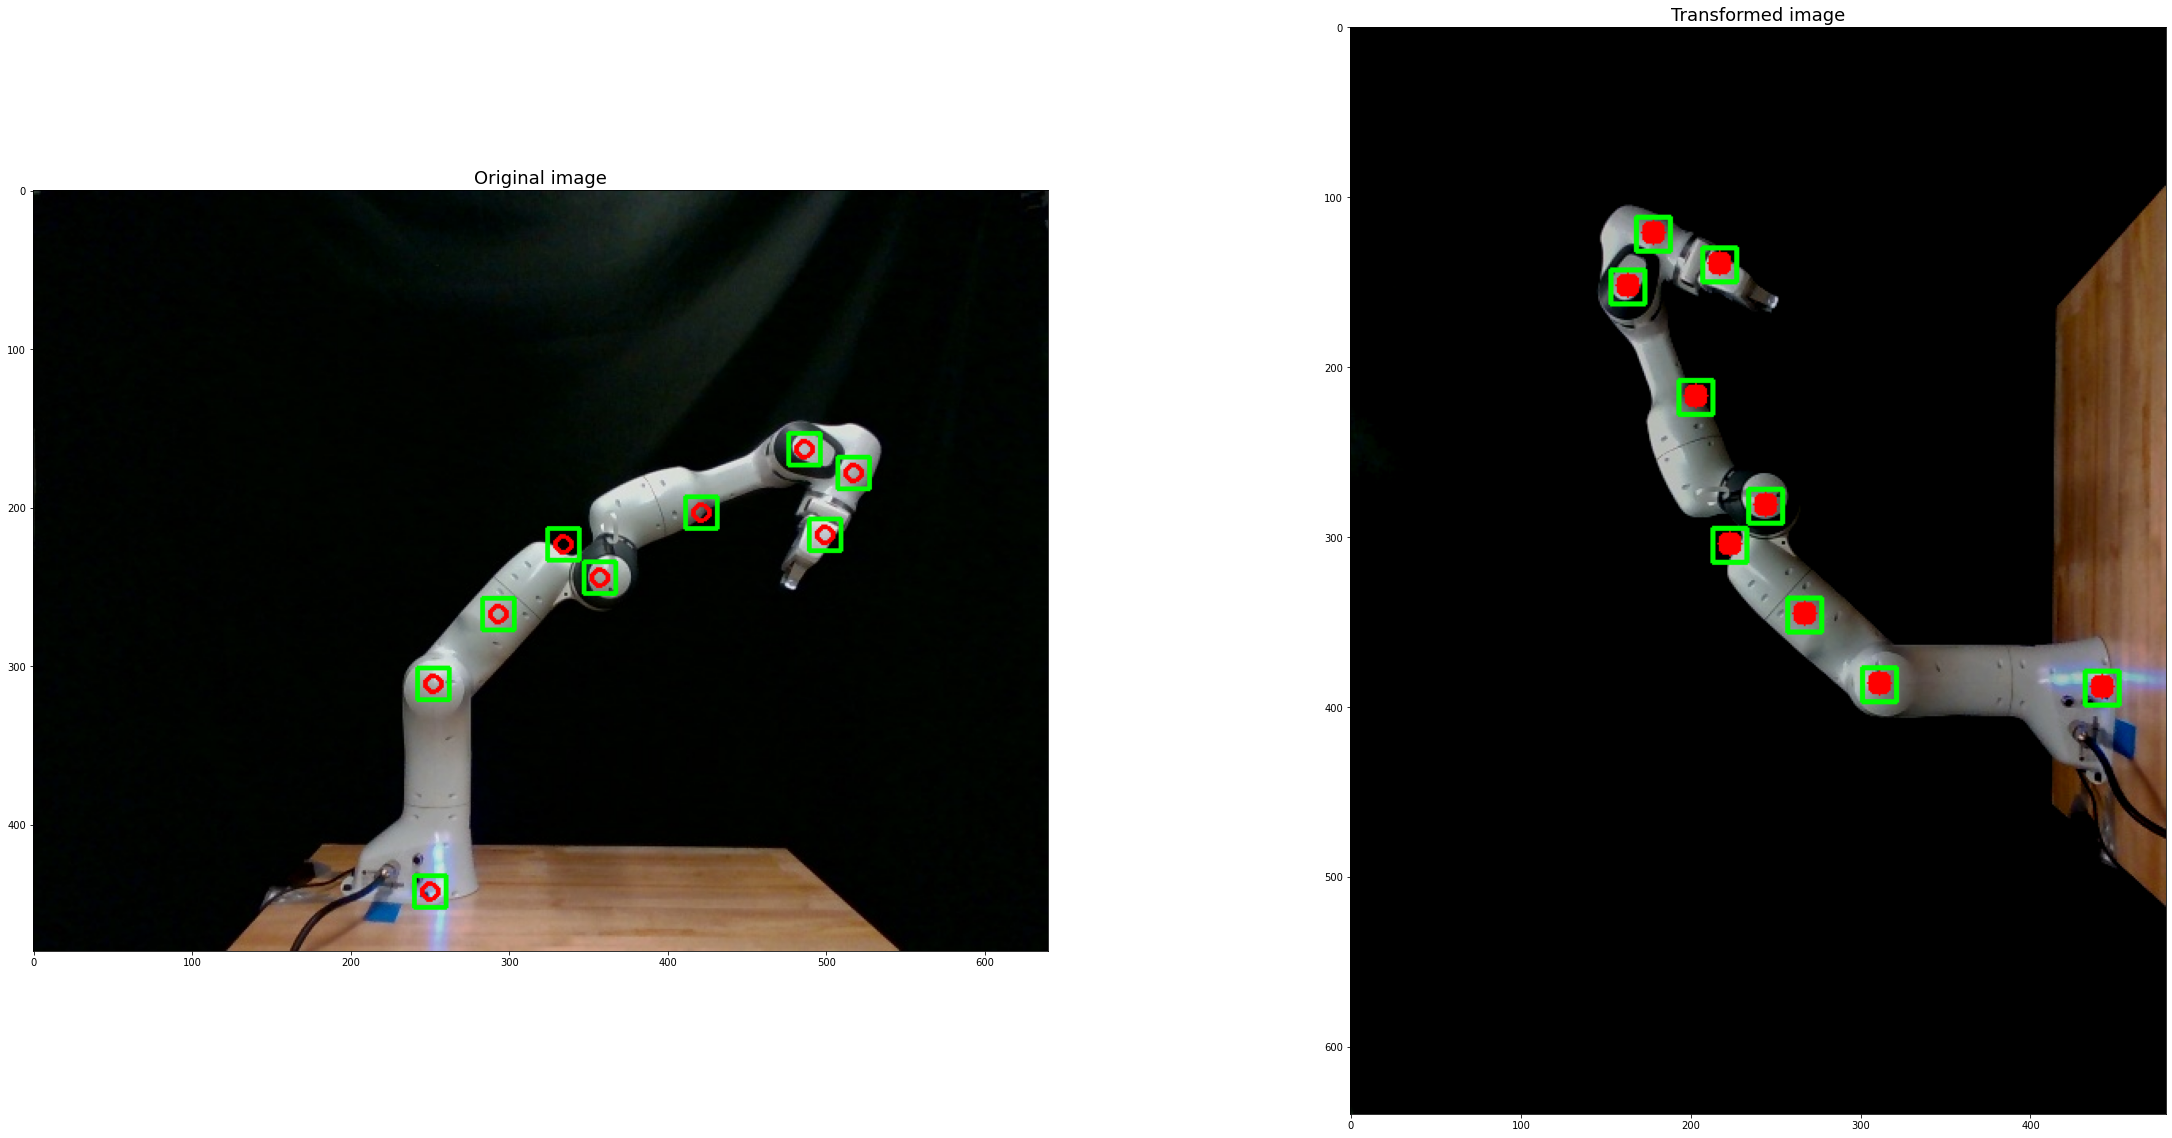

In [22]:
# function to visualize how the transformed data looks 

keypoints_classes_ids2names = {0: 'base_joint', 1: 'joint2', 2: 'joint3', 3: 'joint4', 4: 'joint5', 5: 'joint6',\
                              6:'joint7', 7:'joint8', 8:'joint9'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for idx, kps in enumerate(keypoints):
        for kp in kps:
            image = cv2.circle(image.copy(), tuple(kp), 2, (255,0,0), 10)
#         image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)
        
        return image

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        print(keypoints_original)
        for idx, kps in enumerate(keypoints_original):
            print(idx)
            print(kps)
            for kp in kps:
                print(kp)
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 2)
#             image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
        return None
        
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
# for kps in batch1[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints.append([kp[:2] for kp in [kps]])
    
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
# for kps in batch1[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints_original.append([kp[:2] for kp in [kps]])
    
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [ ]:
### made changes in the path ../.local/lib/python3.8/site-packages/albumentations/core/bbox_utils.py

'''def normalize_bbox(bbox: TBox, rows: int, cols: int) -> TBox:
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.

    Args:
        bbox: Denormalized bounding box `(x_min, y_min, x_max, y_max)`.
        rows: Image height.
        cols: Image width.

    Returns:
        Normalized bounding box `(x_min, y_min, x_max, y_max)`.

    Raises:
        ValueError: If rows or cols is less or equal zero

    """

    if rows <= 0:
        raise ValueError("Argument rows must be positive integer")
    if cols <= 0:
        raise ValueError("Argument cols must be positive integer")

    tail: Tuple[Any, ...]
    (x_min, y_min, x_max, y_max), tail = bbox[:4], tuple(bbox[4:])
    
    #x_min, x_max = x_min / cols, x_max / cols
    #y_min, y_max = y_min / rows, y_max / rows
    # next lines added by Jani
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(cols - 1, x_max)
    y_max = min(rows - 1, y_max)
    
    return cast(BoxType, (x_min/cols, y_min/rows, x_max/cols, y_max/rows) + tail)  # type: ignore
'''

### made changes in the path ../.local/lib/python3.8/site-packages/albumentations/core/keypoint_utils.py
'''def check_keypoint(kp, rows, cols):
    for name, value, size in zip(["x", "y"], kp[:2], [cols, rows]):
        value = min(max(0.0, value), size - 1)
        kp = tuple([value if i == idx else x for i, x in enumerate(kp)])
        if not 0 <= value < size:
            raise ValueError(
                "Expected {name} for keypoint {kp} "
                "to be in the range [0.0, {size}], got {value}.".format(kp=kp, name=name, value=value, size=size)
            )
    angle = kp[2]
    if not (0 <= angle < 2 * math.pi):
        raise ValueError(
            "Expected angle for keypoint {kp} to be in the range [0.0, 2 * pi], got {angle}.".format(kp=kp, angle=angle)
        )
    return kp

'''

In [23]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=False,
                                                                   weights_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 8, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [24]:
num_keypoints = 9
model = get_model(num_keypoints, weights_path=None)
model 

/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/jc-merlab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [25]:
total_keypoints = 9

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

split_folder_path = train_test_split(root_dir)

KEYPOINTS_FOLDER_TRAIN = split_folder_path +"/train" #train_test_split(root_dir) +"/train"
KEYPOINTS_FOLDER_VAL = split_folder_path +"/val"
KEYPOINTS_FOLDER_TEST = split_folder_path +"/test"

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
# dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=None, demo=False)
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

# batch_sizes = [3,2]
# epochs_lst = [30,50,100]

# batch_sizes = [3, 2, 1]
# epochs_lst = [25, 30]
batch_sizes = [1]
epochs_lst = [25, 30]

v = 2

for b_size in batch_sizes:
    for epochs in epochs_lst:
        data_loader_train = DataLoader(dataset_train, batch_size=b_size, shuffle=True, collate_fn=collate_fn)
        data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
        data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

        model = get_model(num_keypoints = total_keypoints)
        model.to(device)

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
        num_epochs = epochs

        for epoch in range(num_epochs):
            train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
            lr_scheduler.step()
            
#             if epoch == 25 or epoch == 30 :
#                 PATH = f"/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b{b_size}_e{epoch}_v{v}.pth"        
#                 torch.save(model, PATH)
#                 v+=1 
            
        
        PATH = f"/home/jc-merlab/Pictures/Data/trained_models/kprcnn_plan_b{b_size}_e{epochs}_v{v}_sim.pth"
            
            
        torch.save(model, PATH)
        
           
        


#     evaluate(model, data_loader_val, device)


/home/jc-merlab/Pictures/Data/occ_panda_physical_dataset/split_folder_output


Copying files: 49670 files [00:03, 13280.32 files/s]


KeyboardInterrupt: 

In [ ]:
# Save model weights after training
# torch.save(model.state_dict(), 'keypointsrcnn_weights_120.pth')
# torch.save(model, '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b1_e30_v3.pth')
            
# torch.save(model, PATH)

In [ ]:
KEYPOINTS_FOLDER_VAL = parent_path + "split_folder_output-2023-07-14" +"/val"
dataset_val = ClassDataset(KEYPOINTS_FOLDER_VAL, transform=None, demo=False)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)
iterator = iter(data_loader_val)
len(data_loader_val)

In [ ]:
evaluate(model, data_loader_val, device)

In [ ]:
# weights_path = '/home/user/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/data/trained_models/keypointsrcnn_weights_ld_b1_e25_v9.pth'
weights_path = PATH
model = torch.load(weights_path).to(device)
model.eval()

In [ ]:
data_iterator = iter(data_loader_val)
i = 1
while True:
    try:
        images, targets = next(data_iterator)
        images = list(img.to(device) for img in images)
        with torch.no_grad():
            outputs = model(images)
            images = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
            scores = outputs[0]['scores'].detach().cpu().numpy()

            high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
            post_nms_idxs = torchvision.ops.nms(outputs[0]['boxes'][high_scores_idxs], outputs[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)
            keypoints = []
            for kps in outputs[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
                keypoints.append([list(map(int, kp[:2])) for kp in kps])

            bboxes = []
            for bbox in outputs[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
                bboxes.append(list(map(int, bbox.tolist())))
            img = visualize(images, bboxes, keypoints)
#             cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results_01/out_image_" + str(i) + ".jpg", img)
            cv2.imshow(f'image{i}', img)

            cv2.waitKey(0)
            cv2.destroyWindow(f'image{i}')

            
            i = i+1

            # Calculate loss and metrics for evaluation here.
    except StopIteration:
        break         
        


In [ ]:
weights_path = '/home/user/Workspace/WPI/Summer2023/ws/duc_repo/src/panda_test/data/trained_models/keypointsrcnn_weights_ld_b1_e25_v1.pth'
model = torch.load(weights_path).to(device)

images1, targets1 = next(iterator)
images2, targets2 = next(iterator)
images3, targets3 = next(iterator)
images4, targets4 = next(iterator)
# images, targets = next(iterator)

print(type(images1))


images1 = list(image1.to(device) for image1 in images1)
images2 = list(image2.to(device) for image2 in images2)
images3 = list(image3.to(device) for image3 in images3)
images4 = list(image4.to(device) for image4 in images4)
# images = list(image.to(device) for image in images)

print(type(images1))

with torch.no_grad():
    model.to(device)
    model.eval()
    output1 = model(images1)
    output2 = model(images2)
    output3 = model(images3)
    output4 = model(images4)
#     output = model(image)

# print("Predictions: \n", output1)



In [ ]:
print("Predictions: \n", output1)


In [ ]:
for i, (images, targets) in enumerate(data_loader_val)

In [ ]:
import cv2
import numpy as np
import torch
import time

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b1_e25_v2.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# print(type(model))
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/home/jc-merlab/Pictures/Data/inference_data/test_video_3d.avi')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
i = 0
print(type(i))
while(cap.isOpened()):
  # Capture frame-by-frame
    print(i)
    ret, frame = cap.read()
    if ret == True:        
#         img = cv2.imread(frame)
        image = Image.fromarray(frame)

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
    
        with torch.no_grad():
            model.to(device)
            model.eval()
            start = time.time(now)
            output = model(image)
            stop = time.time(now)
            print("time", (stop - start))

        image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        # Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
        # Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
        # Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])

        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
        img = visualize(image, bboxes, keypoints)
        
        cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results_01/out_image_" + str(i) + ".jpg", img)
    
    else:
        break
        
    i = i+1
    
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
image1 = (images1[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores1 = output1[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores1 > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output1[0]['boxes'][high_scores_idxs], output1[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output1[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])
    
print(keypoints)

bboxes = []
for bbox in output1[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
image = visualize(image1, bboxes, keypoints)






In [ ]:
image2 = (images2[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output2[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output2[0]['boxes'][high_scores_idxs], output2[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output2[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output2[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image2, bboxes, keypoints)

In [ ]:
image3 = (images3[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores3 = output3[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output3[0]['boxes'][high_scores_idxs], output3[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output3[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output3[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image3, bboxes, keypoints)

In [ ]:
image4 = (images4[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores4 = output4[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output4[0]['boxes'][high_scores_idxs], output4[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output4[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output4[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image4, bboxes, keypoints)

In [ ]:
image = Image.open("/home/jc-merlab/428.jpg")
print(type(image))

image = F.to_tensor(image).to(device)
image.unsqueeze_(0)
print(image.shape)
image = list(image)
# print(type(images))
# images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(image)
    
    

In [ ]:
image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append(list(map(int, kps[0,0:2])))
#     keypoints.append([list(map(int, kp[:2])) for kp in kps])
keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)

In [ ]:
import cv2
import numpy as np

weights_path = 'keypointsrcnn_weights.pth'
model = get_model(num_keypoints=6, weights_path=weights_path)
model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)

model.eval()

# print(type(model))
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/home/jc-merlab/nov1_v1.avi')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
i = 0
print(type(i))
while(cap.isOpened()):
  # Capture frame-by-frame
    print(i)
    ret, frame = cap.read()
    if ret == True:        
#         img = cv2.imread(frame)
        image = Image.fromarray(frame)

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
    
        with torch.no_grad():
            model.to(device)
            model.eval()
            output = model(image)

        image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        # Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
        # Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
        # Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])

        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
        img = visualize(image, bboxes, keypoints)
        
        cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results/out_image_" + str(i) + ".jpg", img)
        
    i = i+1
    
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder="/home/jc-merlab/Pictures/Data/video_results/"

fps=1

image_files = [os.path.join(image_folder,img)
               for img in os.listdir(image_folder)
               if img.endswith(".jpg")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('my_video.mp4')

In [ ]:
2500//72

In [ ]:
import cv2
import numpy as np
import torch
import time

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_ld_b1_e25_v2.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# print(type(model))
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/home/jc-merlab/Pictures/Data/inference_data/test_video_3d.avi')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
i = 0
print(type(i))
while(cap.isOpened()):
  # Capture frame-by-frame
    print(i)
    ret, frame = cap.read()
    if ret == True:        
#         img = cv2.imread(frame)
        image = Image.fromarray(frame)

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
        
    
        with torch.no_grad():
            model.to(device)
            model.eval()
            start = time.time(now)
            output = model(image)
            stop = time.time(now)
            print("time", (stop - start))

        image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        # Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
        # Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
        # Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])

        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
        img = visualize(image, bboxes, keypoints)
        
        labels = []
        for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            labels.append(label)
        keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
        
        
        cv2.imwrite("/home/jc-merlab/Pictures/Data/video_results_01/out_image_" + str(i) + ".jpg", img)
    
    else:
        break
        
    i = i+1
    
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
import torch
import time
import os
import json
import torch, torchvision
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms import functional as F
import shutil

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_weights_sim_b1_e25_v0.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# Specify input and output folders
input_folder = '/home/jc-merlab/Pictures/Data/occ_sim_append/'
output_frames_folder = '/home/jc-merlab/Pictures/Data/occ_sim_append_op/'
# output_json_folder = '/home/jc-merlab/Pictures/Data/keypoint_jsons'

# Check if output folders exist, create them if not
os.makedirs(output_frames_folder, exist_ok=True)
# os.makedirs(output_json_folder, exist_ok=True)

# Process images in the folder
i = 0
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)  

        image = F.to_tensor(image).to(device)
        image.unsqueeze_(0)
        image = list(image)
        # print(type(images))
        # images = list(image.to(device) for image in images)

        with torch.no_grad():
            model.to(device)
            model.eval()
            output = model(image)
            image = (image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append(list(map(int, kps[0,0:2])))
            
        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
       
        labels = []
        for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            labels.append(label)
            
        keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
        print(keypoints_)
        bbox_ = [x for _,x in sorted(zip(labels,bboxes))]
        print(bbox_[3])
        
        # Modify the 4th keypoint as per the requirement
#         if len(keypoints_) >= 4 and len(bbox_) >= 4:
#             fourth_bbox = bbox_[3]
#             # Replace 4th keypoint with the top-left corner of the 4th bounding box
#             keypoints_[3] = [fourth_bbox[0], fourth_bbox[1]]
#             # Append the bottom-right corner of the 4th bounding box as a new keypoint
#             keypoints_.append([fourth_bbox[2], fourth_bbox[3]])
            
        print(keypoints_)

        # Generate JSON data
        image_filename_base = os.path.splitext(filename)[0]  # Remove '.jpg' extension
        json_data = {
            "id": i,
            "image_rgb": filename,  
            "keypoints": [[kp] for kp in keypoints_]
        }

        # Copy image to output folder
        output_image_path = os.path.join(output_frames_folder, filename)
        shutil.copyfile(image_path, output_image_path)

        # Save JSON with matching filename
        output_json_path = os.path.join(output_frames_folder, f"{image_filename_base}.json") 
        with open(output_json_path, 'w') as f:
            json.dump(json_data, f)

        i += 1

print("Processing complete!")

In [1]:
import os
import cv2
import torch
import torchvision
import numpy as np
import json
import shutil
from torchvision.transforms import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

weights_path = '/home/jc-merlab/Pictures/Data/trained_models/keypointsrcnn_planning_b1_e100_v4.pth'
model = torch.load(weights_path).to(device)
# model = get_model(num_keypoints=6, weights_path=weights_path)
# model.load_state_dict(torch.load('keypointsrcnn_weights.pth'))

model.to(device)
model.eval()

# Assuming the necessary imports are done
# Assuming the model is loaded and device is set as in your initial code

# Specify input and output folders
input_folder = '/home/jc-merlab/Pictures/Data/occ_panda_phys_test_data/'
output_frames_folder = '/home/jc-merlab/Pictures/Data/occ_phys_test_data/panda_kprcnn_op/'

# Check if output folders exist, create them if not
os.makedirs(output_frames_folder, exist_ok=True)

def load_ground_truth(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    # ground_truth_keypoints = [[int(kp[0][0]), int(kp[0][1])] for kp in data['keypoints']]
    ground_truth_keypoints = [[int(kp[0][0]), int(kp[0][1]), kp[0][2]] for kp in data['keypoints']]
    return ground_truth_keypoints

def calculate_accuracy(predicted_keypoints, ground_truth_keypoints, margin=10):
    """
    Calculate the accuracy of predicted keypoints within a margin of 10 pixels.
    Also calculate accuracy for invisible keypoints within a margin of 5 pixels.
    """
    correct = 0
    total = len(ground_truth_keypoints)
    
    correct_invisible = 0
    total_invisible = 0

    for pred_kp, gt_kp in zip(predicted_keypoints, ground_truth_keypoints):
        pred_kp = pred_kp.cpu().numpy()  # Move tensor to CPU and convert to NumPy array
        dist = np.linalg.norm(np.array(pred_kp[:2]) - np.array(gt_kp[:2]))  # Use only x, y for distance calculation
#         print("GT Keypoints", gt_kp)
        if gt_kp[2] == 0:  # Invisible keypoint
            total_invisible += 1
            if dist <= margin:  # Margin for invisible keypoints
                correct_invisible += 1
        else:  # Visible keypoint
            if dist <= margin:
                correct += 1
    
    correct_total = correct + correct_invisible
    accuracy = (correct_total / total) * 100
    invisible_accuracy = (correct_invisible / total_invisible) * 100 if total_invisible > 0 else 0
    return accuracy, invisible_accuracy, total_invisible

# Process images in the folder
accuracies = []
invisible_accuracies = []
total_invisible_keypoints = 0
total_inference_time = []
i = 0
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        tensor_image = F.to_tensor(image).to(device)
        tensor_image.unsqueeze_(0)
        tensor_image = list(tensor_image)

        with torch.no_grad():
            output = model(tensor_image)
            tensor_image = (tensor_image[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        
        scores = output[0]['scores'].detach().cpu().numpy()

        high_scores_idxs = np.where(scores > 0.01)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)
        confidence = output[0]['scores'][high_scores_idxs].detach().cpu().numpy()

#         keypoints = []
#         for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             keypoints.append(list(map(int, kps[0,0:2])))
            

            
#         bboxes = []
#         for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             bboxes.append(list(map(int, bbox.tolist())))
            
        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
       
#         labels = []
#         for label in output[0]['labels'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
#             labels.append(label)
            
        labels = []
        for label in output[0]['labels'][high_scores_idxs].detach().cpu().numpy():
            labels.append(label)
            
        keypoints = []
        for idx, kps in enumerate(output[0]['keypoints'][high_scores_idxs].detach().cpu().numpy()):
            keypoints.append(list(map(int, kps[0, 0:2])) + [confidence[idx]] + [labels[idx]])
            
        keypoints = [torch.tensor(kp, dtype=torch.float32).to(device) if not isinstance(kp, torch.Tensor) else kp for kp in keypoints]
        keypoints = torch.stack(keypoints).to(device)
        
        unique_labels, best_keypoint_indices = torch.unique(keypoints[:, 3], return_inverse=True)
        best_scores, best_indices = torch.max(keypoints[:, 2].unsqueeze(0) * (best_keypoint_indices == torch.arange(len(unique_labels)).unsqueeze(1).cuda()), dim=1)
        keypoints = keypoints[best_indices]
            
#         keypoints_ = [x for _,x in sorted(zip(labels,keypoints))]
        # Load ground truth keypoints
        json_filename = filename.split('.')[0] + '.json'  # Construct JSON filename
        json_path = os.path.join(input_folder, json_filename)
        ground_truth_keypoints = load_ground_truth(json_path) 
        
#         print(keypoints)

        # Visualize keypoints on the image
        for point in keypoints:
            x,y, c, l = point
            cv2.circle(image, (int(x), int(y)), 9, (255, 0, 0), -1)  # Draws a blue circle on each keypoint
            
        # Ground truth keypoints in red
        for x, y, _ in ground_truth_keypoints:
            cv2.circle(image, (x, y), radius=5, color=(0, 0, 255), thickness=-1)

        # Save the modified image to the output folder
        output_image_path = os.path.join(output_frames_folder, filename)
        cv2.imwrite(output_image_path, image)
        
        # Calculate and store accuracy
        accuracy, invisible_accuracy, num_invisible = calculate_accuracy(keypoints, ground_truth_keypoints, margin=10)
        accuracies.append(accuracy)
        invisible_accuracies.append(invisible_accuracy)
#         total_inference_time.append(inference_time)
        total_invisible_keypoints += num_invisible
        print(f"Accuracy for {filename}: {accuracy}%")
        print(f"Invisible Keypoint Accuracy for {filename}: {invisible_accuracy}%")

        i += 1
        
# Print overall accuracy
overall_accuracy = np.mean(accuracies)
overall_invisible_accuracy = np.mean(invisible_accuracies)
avg_inference_time = np.mean(total_inference_time)
print(f"Overall accuracy: {overall_accuracy}%")
print(f"Overall invisible keypoint accuracy: {overall_invisible_accuracy}%")
print(f"Total number of invisible keypoints: {total_invisible_keypoints}")
# print(f"Average inference time: {avg_inference_time}")


print("Processing complete!")

cuda
Accuracy for 012418.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012418.jpg: 0.0%
Accuracy for 012419.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 012419.jpg: 0.0%
Accuracy for 012420.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012420.jpg: 0.0%
Accuracy for 012421.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012421.jpg: 0%
Accuracy for 012422.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012422.jpg: 0.0%
Accuracy for 012423.jpg: 0.0%
Invisible Keypoint Accuracy for 012423.jpg: 0.0%
Accuracy for 012424.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012424.jpg: 0.0%
Accuracy for 012425.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 012425.jpg: 50.0%
Accuracy for 012426.jpg: 0.0%
Invisible Keypoint Accuracy for 012426.jpg: 0.0%
Accuracy for 012427.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012427.jpg: 0.0%
Accuracy for 012428.jpg: 0.0%
Invisible Keypoint Accuracy for 012428.jpg: 0.0%
Accuracy for 01

Accuracy for 012508.jpg: 0.0%
Invisible Keypoint Accuracy for 012508.jpg: 0.0%
Accuracy for 012509.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012509.jpg: 0.0%
Accuracy for 012510.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 012510.jpg: 0.0%
Accuracy for 012511.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012511.jpg: 0.0%
Accuracy for 012512.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 012512.jpg: 33.33333333333333%
Accuracy for 012513.jpg: 0.0%
Invisible Keypoint Accuracy for 012513.jpg: 0.0%
Accuracy for 012514.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 012514.jpg: 0.0%
Accuracy for 012515.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 012515.jpg: 0.0%
Accuracy for 012516.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 012516.jpg: 0.0%
Accuracy for 012517.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012517.jpg: 0.0%
Accuracy for 012518.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 012518.j

Accuracy for 012600.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 012600.jpg: 0.0%
Accuracy for 012601.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 012601.jpg: 100.0%
Accuracy for 012602.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012602.jpg: 0.0%
Accuracy for 012603.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 012603.jpg: 100.0%
Accuracy for 012604.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012604.jpg: 0.0%
Accuracy for 012605.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012605.jpg: 0.0%
Accuracy for 012606.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012606.jpg: 0.0%
Accuracy for 012607.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 012607.jpg: 0.0%
Accuracy for 012608.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 012608.jpg: 0.0%
Accuracy for 012609.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012609.jpg: 0.0%
Accuracy for 012610.jpg: 22.22222222222222%
Invisible Keypoint Acc

Accuracy for 012692.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012692.jpg: 0.0%
Accuracy for 012693.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 012693.jpg: 0.0%
Accuracy for 012694.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 012694.jpg: 0.0%
Accuracy for 012695.jpg: 0.0%
Invisible Keypoint Accuracy for 012695.jpg: 0.0%
Accuracy for 012696.jpg: 0.0%
Invisible Keypoint Accuracy for 012696.jpg: 0.0%
Accuracy for 012697.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 012697.jpg: 0.0%
Accuracy for 012698.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012698.jpg: 0.0%
Accuracy for 012699.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012699.jpg: 0.0%
Accuracy for 012700.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012700.jpg: 0.0%
Accuracy for 012701.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 012701.jpg: 0%
Accuracy for 012702.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012702.jpg: 50.0%
Accura

Accuracy for 012785.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 012785.jpg: 0.0%
Accuracy for 012786.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 012786.jpg: 0.0%
Accuracy for 012787.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 012787.jpg: 0.0%
Accuracy for 012788.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 012788.jpg: 0.0%
Accuracy for 012789.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012789.jpg: 0.0%
Accuracy for 012790.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 012790.jpg: 100.0%
Accuracy for 012791.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012791.jpg: 25.0%
Accuracy for 012792.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012792.jpg: 0.0%
Accuracy for 012793.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 012793.jpg: 50.0%
Accuracy for 012794.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012794.jpg: 0.0%
Accuracy for 012795.jpg: 77.77777777777779%
Invisible Keypoint Acc

Accuracy for 012877.jpg: 0.0%
Invisible Keypoint Accuracy for 012877.jpg: 0.0%
Accuracy for 012878.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012878.jpg: 0.0%
Accuracy for 012879.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 012879.jpg: 0.0%
Accuracy for 012880.jpg: 0.0%
Invisible Keypoint Accuracy for 012880.jpg: 0.0%
Accuracy for 012881.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 012881.jpg: 0.0%
Accuracy for 012882.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012882.jpg: 0.0%
Accuracy for 012883.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012883.jpg: 0.0%
Accuracy for 012884.jpg: 0.0%
Invisible Keypoint Accuracy for 012884.jpg: 0.0%
Accuracy for 012885.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012885.jpg: 0.0%
Accuracy for 012886.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012886.jpg: 0.0%
Accuracy for 012887.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 012887.jpg: 0.0%
Accuracy for 012888

Accuracy for 012968.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 012968.jpg: 0.0%
Accuracy for 012969.jpg: 0.0%
Invisible Keypoint Accuracy for 012969.jpg: 0.0%
Accuracy for 012970.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 012970.jpg: 0.0%
Accuracy for 012971.jpg: 0.0%
Invisible Keypoint Accuracy for 012971.jpg: 0.0%
Accuracy for 012972.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012972.jpg: 0.0%
Accuracy for 012973.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012973.jpg: 0.0%
Accuracy for 012974.jpg: 0.0%
Invisible Keypoint Accuracy for 012974.jpg: 0.0%
Accuracy for 012975.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 012975.jpg: 0.0%
Accuracy for 012976.jpg: 0.0%
Invisible Keypoint Accuracy for 012976.jpg: 0.0%
Accuracy for 012977.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 012977.jpg: 0.0%
Accuracy for 012978.jpg: 0.0%
Invisible Keypoint Accuracy for 012978.jpg: 0.0%
Accuracy for 012979.jpg: 0.0%
Invisible Keypoin

Accuracy for 013059.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013059.jpg: 0.0%
Accuracy for 013060.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013060.jpg: 0.0%
Accuracy for 013061.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013061.jpg: 0.0%
Accuracy for 013062.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013062.jpg: 0.0%
Accuracy for 013063.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013063.jpg: 0.0%
Accuracy for 013064.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 013064.jpg: 0.0%
Accuracy for 013065.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013065.jpg: 0.0%
Accuracy for 013066.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013066.jpg: 0.0%
Accuracy for 013067.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 013067.jpg: 100.0%
Accuracy for 013068.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013068.jpg: 66.66666666666666%
Accuracy for 013069.jpg: 22.22222222222222%
Invisible 

Accuracy for 013150.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013150.jpg: 0.0%
Accuracy for 013151.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013151.jpg: 0.0%
Accuracy for 013152.jpg: 0.0%
Invisible Keypoint Accuracy for 013152.jpg: 0.0%
Accuracy for 013153.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013153.jpg: 50.0%
Accuracy for 013154.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013154.jpg: 0.0%
Accuracy for 013155.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 013155.jpg: 0.0%
Accuracy for 013156.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013156.jpg: 0.0%
Accuracy for 013157.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013157.jpg: 0.0%
Accuracy for 013158.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013158.jpg: 0.0%
Accuracy for 013159.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013159.jpg: 0.0%
Accuracy for 013160.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013160.

Accuracy for 013241.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013241.jpg: 50.0%
Accuracy for 013242.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013242.jpg: 0.0%
Accuracy for 013243.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013243.jpg: 33.33333333333333%
Accuracy for 013244.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013244.jpg: 0.0%
Accuracy for 013245.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 013245.jpg: 0.0%
Accuracy for 013246.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 013246.jpg: 0.0%
Accuracy for 013247.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013247.jpg: 0.0%
Accuracy for 013248.jpg: 0.0%
Invisible Keypoint Accuracy for 013248.jpg: 0.0%
Accuracy for 013249.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013249.jpg: 0.0%
Accuracy for 013250.jpg: 0.0%
Invisible Keypoint Accuracy for 013250.jpg: 0.0%
Accuracy for 013251.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013251.

Accuracy for 013333.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 013333.jpg: 0.0%
Accuracy for 013334.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 013334.jpg: 0.0%
Accuracy for 013335.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 013335.jpg: 0.0%
Accuracy for 013336.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013336.jpg: 40.0%
Accuracy for 013337.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 013337.jpg: 0.0%
Accuracy for 013338.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013338.jpg: 0.0%
Accuracy for 013339.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013339.jpg: 0.0%
Accuracy for 013340.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013340.jpg: 0.0%
Accuracy for 013341.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013341.jpg: 0.0%
Accuracy for 013342.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013342.jpg: 0.0%
Accuracy for 013343.jpg: 66.66666666666666%
Invisible Keypoint Accura

Accuracy for 013424.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013424.jpg: 0%
Accuracy for 013425.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013425.jpg: 0.0%
Accuracy for 013426.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013426.jpg: 0.0%
Accuracy for 013427.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013427.jpg: 0.0%
Accuracy for 013428.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013428.jpg: 50.0%
Accuracy for 013429.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013429.jpg: 0.0%
Accuracy for 013430.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013430.jpg: 0.0%
Accuracy for 013431.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013431.jpg: 0.0%
Accuracy for 013432.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013432.jpg: 0.0%
Accuracy for 013433.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013433.jpg: 0.0%
Accuracy for 013434.jpg: 0.0%
Invisible Keypoint Accuracy for 013434.jp

Accuracy for 013516.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013516.jpg: 33.33333333333333%
Accuracy for 013517.jpg: 100.0%
Invisible Keypoint Accuracy for 013517.jpg: 100.0%
Accuracy for 013518.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 013518.jpg: 100.0%
Accuracy for 013519.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013519.jpg: 0.0%
Accuracy for 013520.jpg: 0.0%
Invisible Keypoint Accuracy for 013520.jpg: 0.0%
Accuracy for 013521.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013521.jpg: 0.0%
Accuracy for 013522.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013522.jpg: 33.33333333333333%
Accuracy for 013523.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013523.jpg: 0.0%
Accuracy for 013524.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 013524.jpg: 100.0%
Accuracy for 013525.jpg: 0.0%
Invisible Keypoint Accuracy for 013525.jpg: 0.0%
Accuracy for 013526.jpg: 0.0%
Invisible Keypoint Accuracy for 013526.jpg: 0.

Accuracy for 013607.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013607.jpg: 0.0%
Accuracy for 013608.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 013608.jpg: 50.0%
Accuracy for 013609.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013609.jpg: 0.0%
Accuracy for 013610.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013610.jpg: 0.0%
Accuracy for 013611.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013611.jpg: 0.0%
Accuracy for 013612.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013612.jpg: 0.0%
Accuracy for 013613.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 013613.jpg: 0.0%
Accuracy for 013614.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 013614.jpg: 0.0%
Accuracy for 013615.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013615.jpg: 0.0%
Accuracy for 013616.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013616.jpg: 0.0%
Accuracy for 013617.jpg: 33.33333333333333%
Invisible Keypoint Accura

Accuracy for 013698.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013698.jpg: 0.0%
Accuracy for 013699.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013699.jpg: 0.0%
Accuracy for 013700.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013700.jpg: 0.0%
Accuracy for 013701.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 013701.jpg: 25.0%
Accuracy for 013702.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 013702.jpg: 0.0%
Accuracy for 013703.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013703.jpg: 0.0%
Accuracy for 013704.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013704.jpg: 0.0%
Accuracy for 013705.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013705.jpg: 0.0%
Accuracy for 013706.jpg: 0.0%
Invisible Keypoint Accuracy for 013706.jpg: 0.0%
Accuracy for 013707.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013707.jpg: 0.0%
Accuracy for 013708.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013708.

Accuracy for 013789.jpg: 0.0%
Invisible Keypoint Accuracy for 013789.jpg: 0.0%
Accuracy for 013790.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013790.jpg: 0.0%
Accuracy for 013791.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013791.jpg: 0.0%
Accuracy for 013792.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013792.jpg: 0.0%
Accuracy for 013793.jpg: 0.0%
Invisible Keypoint Accuracy for 013793.jpg: 0.0%
Accuracy for 013794.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013794.jpg: 0.0%
Accuracy for 013795.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013795.jpg: 0.0%
Accuracy for 013796.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013796.jpg: 33.33333333333333%
Accuracy for 013797.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 013797.jpg: 0.0%
Accuracy for 013798.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 013798.jpg: 0.0%
Accuracy for 013799.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013799.j

Accuracy for 013879.jpg: 0.0%
Invisible Keypoint Accuracy for 013879.jpg: 0.0%
Accuracy for 013880.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 013880.jpg: 50.0%
Accuracy for 013881.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013881.jpg: 0.0%
Accuracy for 013882.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013882.jpg: 0.0%
Accuracy for 013883.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 013883.jpg: 0.0%
Accuracy for 013884.jpg: 0.0%
Invisible Keypoint Accuracy for 013884.jpg: 0.0%
Accuracy for 013885.jpg: 0.0%
Invisible Keypoint Accuracy for 013885.jpg: 0.0%
Accuracy for 013886.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013886.jpg: 0%
Accuracy for 013887.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013887.jpg: 50.0%
Accuracy for 013888.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 013888.jpg: 0%
Accuracy for 013889.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013889.jpg: 0.0%
Accuracy for 013890.j

Accuracy for 013972.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 013972.jpg: 0.0%
Accuracy for 013973.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013973.jpg: 50.0%
Accuracy for 013974.jpg: 0.0%
Invisible Keypoint Accuracy for 013974.jpg: 0.0%
Accuracy for 013975.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013975.jpg: 0.0%
Accuracy for 013976.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013976.jpg: 0.0%
Accuracy for 013977.jpg: 100.0%
Invisible Keypoint Accuracy for 013977.jpg: 100.0%
Accuracy for 013978.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 013978.jpg: 0.0%
Accuracy for 013979.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013979.jpg: 0.0%
Accuracy for 013980.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 013980.jpg: 0.0%
Accuracy for 013981.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 013981.jpg: 0.0%
Accuracy for 013982.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 013982.jpg: 0.0%


Accuracy for 014064.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014064.jpg: 25.0%
Accuracy for 014065.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014065.jpg: 0%
Accuracy for 014066.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 014066.jpg: 0.0%
Accuracy for 014067.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 014067.jpg: 0.0%
Accuracy for 014068.jpg: 0.0%
Invisible Keypoint Accuracy for 014068.jpg: 0.0%
Accuracy for 014069.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014069.jpg: 0.0%
Accuracy for 014070.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014070.jpg: 0.0%
Accuracy for 014071.jpg: 0.0%
Invisible Keypoint Accuracy for 014071.jpg: 0.0%
Accuracy for 014072.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014072.jpg: 33.33333333333333%
Accuracy for 014073.jpg: 0.0%
Invisible Keypoint Accuracy for 014073.jpg: 0.0%
Accuracy for 014074.jpg: 0.0%
Invisible Keypoint Accuracy for 014074.jpg: 0.0%
Accuracy for 014075.

Accuracy for 014154.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014154.jpg: 0.0%
Accuracy for 014155.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014155.jpg: 0.0%
Accuracy for 014156.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014156.jpg: 0.0%
Accuracy for 014157.jpg: 0.0%
Invisible Keypoint Accuracy for 014157.jpg: 0.0%
Accuracy for 014158.jpg: 0.0%
Invisible Keypoint Accuracy for 014158.jpg: 0.0%
Accuracy for 014159.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014159.jpg: 0.0%
Accuracy for 014160.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014160.jpg: 0.0%
Accuracy for 014161.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014161.jpg: 0.0%
Accuracy for 014162.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014162.jpg: 0.0%
Accuracy for 014163.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014163.jpg: 0.0%
Accuracy for 014164.jpg: 0.0%
Invisible Keypoint Accuracy for 014164.jpg: 0.0%
Accuracy for 014165

Accuracy for 014246.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014246.jpg: 0.0%
Accuracy for 014247.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014247.jpg: 0.0%
Accuracy for 014248.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014248.jpg: 0.0%
Accuracy for 014249.jpg: 0.0%
Invisible Keypoint Accuracy for 014249.jpg: 0.0%
Accuracy for 014250.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014250.jpg: 0.0%
Accuracy for 014251.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 014251.jpg: 0.0%
Accuracy for 014252.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014252.jpg: 0.0%
Accuracy for 014253.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014253.jpg: 0.0%
Accuracy for 014254.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014254.jpg: 0.0%
Accuracy for 014255.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 014255.jpg: 0.0%
Accuracy for 014256.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014256.j

Accuracy for 014337.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014337.jpg: 0.0%
Accuracy for 014338.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014338.jpg: 0.0%
Accuracy for 014339.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014339.jpg: 0.0%
Accuracy for 014340.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014340.jpg: 0.0%
Accuracy for 014341.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 014341.jpg: 0%
Accuracy for 014342.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014342.jpg: 0.0%
Accuracy for 014343.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014343.jpg: 0.0%
Accuracy for 014344.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 014344.jpg: 50.0%
Accuracy for 014345.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 014345.jpg: 25.0%
Accuracy for 014346.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 014346.jpg: 50.0%
Accuracy for 014347.jpg: 22.22222222222222%
Invisible Keypoint Accura

Accuracy for 014427.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014427.jpg: 0.0%
Accuracy for 014428.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 014428.jpg: 0.0%
Accuracy for 014429.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014429.jpg: 0.0%
Accuracy for 014430.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014430.jpg: 0.0%
Accuracy for 014431.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014431.jpg: 0.0%
Accuracy for 014432.jpg: 0.0%
Invisible Keypoint Accuracy for 014432.jpg: 0.0%
Accuracy for 014433.jpg: 0.0%
Invisible Keypoint Accuracy for 014433.jpg: 0.0%
Accuracy for 014434.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014434.jpg: 50.0%
Accuracy for 014435.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014435.jpg: 0.0%
Accuracy for 014436.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 014436.jpg: 50.0%
Accuracy for 014437.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014437.jpg: 0.0%
Acc

Accuracy for 014520.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 014520.jpg: 0.0%
Accuracy for 014521.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014521.jpg: 50.0%
Accuracy for 014522.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014522.jpg: 0.0%
Accuracy for 014523.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014523.jpg: 0%
Accuracy for 014524.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014524.jpg: 25.0%
Accuracy for 014525.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 014525.jpg: 0.0%
Accuracy for 014526.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014526.jpg: 0.0%
Accuracy for 014527.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 014527.jpg: 0%
Accuracy for 014528.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014528.jpg: 0.0%
Accuracy for 014529.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014529.jpg: 0.0%
Accuracy for 014530.jpg: 11.11111111111111%
Invisible Keypoint Accuracy 

Accuracy for 014612.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014612.jpg: 0.0%
Accuracy for 014613.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014613.jpg: 0.0%
Accuracy for 014614.jpg: 0.0%
Invisible Keypoint Accuracy for 014614.jpg: 0.0%
Accuracy for 014615.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014615.jpg: 0.0%
Accuracy for 014616.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 014616.jpg: 25.0%
Accuracy for 014617.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014617.jpg: 66.66666666666666%
Accuracy for 014618.jpg: 0.0%
Invisible Keypoint Accuracy for 014618.jpg: 0.0%
Accuracy for 014619.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 014619.jpg: 33.33333333333333%
Accuracy for 014620.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014620.jpg: 0.0%
Accuracy for 014621.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 014621.jpg: 0.0%
Accuracy for 014622.jpg: 0.0%
Invisible Keypoint Accuracy for 014622.

Accuracy for 014703.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014703.jpg: 0.0%
Accuracy for 014704.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 014704.jpg: 0.0%
Accuracy for 014705.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014705.jpg: 0.0%
Accuracy for 014706.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014706.jpg: 0.0%
Accuracy for 014707.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014707.jpg: 0.0%
Accuracy for 014708.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014708.jpg: 100.0%
Accuracy for 014709.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014709.jpg: 0.0%
Accuracy for 014710.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014710.jpg: 0.0%
Accuracy for 014711.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014711.jpg: 0.0%
Accuracy for 014712.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014712.jpg: 0.0%
Accuracy for 014713.jpg: 66.66666666666666%
Invisible Keypoint Accur

Accuracy for 014795.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014795.jpg: 0.0%
Accuracy for 014796.jpg: 0.0%
Invisible Keypoint Accuracy for 014796.jpg: 0.0%
Accuracy for 014797.jpg: 0.0%
Invisible Keypoint Accuracy for 014797.jpg: 0.0%
Accuracy for 014798.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014798.jpg: 0.0%
Accuracy for 014799.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014799.jpg: 0.0%
Accuracy for 014800.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014800.jpg: 100.0%
Accuracy for 014801.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014801.jpg: 25.0%
Accuracy for 014802.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014802.jpg: 0.0%
Accuracy for 014803.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014803.jpg: 0.0%
Accuracy for 014804.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 014804.jpg: 0.0%
Accuracy for 014805.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014805.jpg: 0.0%
Ac

Accuracy for 014886.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014886.jpg: 0.0%
Accuracy for 014887.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014887.jpg: 100.0%
Accuracy for 014888.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014888.jpg: 0.0%
Accuracy for 014889.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014889.jpg: 0.0%
Accuracy for 014890.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 014890.jpg: 50.0%
Accuracy for 014891.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014891.jpg: 0.0%
Accuracy for 014892.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 014892.jpg: 0.0%
Accuracy for 014893.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014893.jpg: 0.0%
Accuracy for 014894.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 014894.jpg: 0.0%
Accuracy for 014895.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 014895.jpg: 0.0%
Accuracy for 014896.jpg: 22.22222222222222%
Invisible Keypoint Accu

Accuracy for 014977.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014977.jpg: 0.0%
Accuracy for 014978.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014978.jpg: 0.0%
Accuracy for 014979.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014979.jpg: 0.0%
Accuracy for 014980.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 014980.jpg: 0.0%
Accuracy for 014981.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014981.jpg: 100.0%
Accuracy for 014982.jpg: 0.0%
Invisible Keypoint Accuracy for 014982.jpg: 0.0%
Accuracy for 014983.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 014983.jpg: 0.0%
Accuracy for 014984.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 014984.jpg: 100.0%
Accuracy for 014985.jpg: 0.0%
Invisible Keypoint Accuracy for 014985.jpg: 0.0%
Accuracy for 014986.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 014986.jpg: 25.0%
Accuracy for 014987.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 014987.jpg: 0.0%


Accuracy for 015070.jpg: 0.0%
Invisible Keypoint Accuracy for 015070.jpg: 0.0%
Accuracy for 015071.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015071.jpg: 0.0%
Accuracy for 015072.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 015072.jpg: 0.0%
Accuracy for 015073.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015073.jpg: 0.0%
Accuracy for 015074.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015074.jpg: 0.0%
Accuracy for 015075.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015075.jpg: 0.0%
Accuracy for 015076.jpg: 0.0%
Invisible Keypoint Accuracy for 015076.jpg: 0.0%
Accuracy for 015077.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015077.jpg: 0.0%
Accuracy for 015078.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015078.jpg: 0.0%
Accuracy for 015079.jpg: 0.0%
Invisible Keypoint Accuracy for 015079.jpg: 0.0%
Accuracy for 015080.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015080.jpg: 0.0%
Accuracy for 015081

Accuracy for 015163.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 015163.jpg: 0.0%
Accuracy for 015164.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015164.jpg: 0.0%
Accuracy for 015165.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015165.jpg: 0.0%
Accuracy for 015166.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015166.jpg: 25.0%
Accuracy for 015167.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015167.jpg: 33.33333333333333%
Accuracy for 015168.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015168.jpg: 0.0%
Accuracy for 015169.jpg: 0.0%
Invisible Keypoint Accuracy for 015169.jpg: 0.0%
Accuracy for 015170.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015170.jpg: 0.0%
Accuracy for 015171.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 015171.jpg: 0.0%
Accuracy for 015172.jpg: 0.0%
Invisible Keypoint Accuracy for 015172.jpg: 0.0%
Accuracy for 015173.jpg: 0.0%
Invisible Keypoint Accuracy for 015173.jpg: 0.0%
Accu

Accuracy for 015253.jpg: 0.0%
Invisible Keypoint Accuracy for 015253.jpg: 0.0%
Accuracy for 015254.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015254.jpg: 0.0%
Accuracy for 015255.jpg: 0.0%
Invisible Keypoint Accuracy for 015255.jpg: 0.0%
Accuracy for 015256.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015256.jpg: 0.0%
Accuracy for 015257.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015257.jpg: 0.0%
Accuracy for 015258.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 015258.jpg: 0.0%
Accuracy for 015259.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 015259.jpg: 0.0%
Accuracy for 015260.jpg: 100.0%
Invisible Keypoint Accuracy for 015260.jpg: 100.0%
Accuracy for 015261.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015261.jpg: 0%
Accuracy for 015262.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015262.jpg: 0.0%
Accuracy for 015263.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015263.jpg: 0.0%
Accuracy for 0152

Accuracy for 015343.jpg: 0.0%
Invisible Keypoint Accuracy for 015343.jpg: 0.0%
Accuracy for 015344.jpg: 0.0%
Invisible Keypoint Accuracy for 015344.jpg: 0.0%
Accuracy for 015345.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015345.jpg: 0.0%
Accuracy for 015346.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 015346.jpg: 33.33333333333333%
Accuracy for 015347.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015347.jpg: 0.0%
Accuracy for 015348.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015348.jpg: 0.0%
Accuracy for 015349.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 015349.jpg: 100.0%
Accuracy for 015350.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015350.jpg: 0.0%
Accuracy for 015351.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015351.jpg: 0.0%
Accuracy for 015352.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015352.jpg: 0.0%
Accuracy for 015353.jpg: 0.0%
Invisible Keypoint Accuracy for 015353.jpg: 0.0%
Acc

Accuracy for 015433.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015433.jpg: 0.0%
Accuracy for 015434.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 015434.jpg: 66.66666666666666%
Accuracy for 015435.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 015435.jpg: 0%
Accuracy for 015436.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015436.jpg: 0.0%
Accuracy for 015437.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015437.jpg: 33.33333333333333%
Accuracy for 015438.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015438.jpg: 0.0%
Accuracy for 015439.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015439.jpg: 0.0%
Accuracy for 015440.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015440.jpg: 0.0%
Accuracy for 015441.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015441.jpg: 50.0%
Accuracy for 015442.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015442.jpg: 0.0%
Accuracy for 015443.jpg: 55.55555555555556%

Accuracy for 015525.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 015525.jpg: 0.0%
Accuracy for 015526.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015526.jpg: 0.0%
Accuracy for 015527.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015527.jpg: 0.0%
Accuracy for 015528.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015528.jpg: 33.33333333333333%
Accuracy for 015529.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015529.jpg: 50.0%
Accuracy for 015530.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015530.jpg: 0.0%
Accuracy for 015531.jpg: 0.0%
Invisible Keypoint Accuracy for 015531.jpg: 0.0%
Accuracy for 015532.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 015532.jpg: 100.0%
Accuracy for 015533.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 015533.jpg: 0.0%
Accuracy for 015534.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 015534.jpg: 0.0%
Accuracy for 015535.jpg: 0.0%
Invisible Keypoint Accuracy for 01553

Accuracy for 015616.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015616.jpg: 50.0%
Accuracy for 015617.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015617.jpg: 0.0%
Accuracy for 015618.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 015618.jpg: 0.0%
Accuracy for 015619.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 015619.jpg: 0.0%
Accuracy for 015620.jpg: 0.0%
Invisible Keypoint Accuracy for 015620.jpg: 0.0%
Accuracy for 015621.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015621.jpg: 50.0%
Accuracy for 015622.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 015622.jpg: 0.0%
Accuracy for 015623.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015623.jpg: 0.0%
Accuracy for 015624.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015624.jpg: 0.0%
Accuracy for 015625.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015625.jpg: 0.0%
Accuracy for 015626.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 015626

Accuracy for 015707.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 015707.jpg: 0.0%
Accuracy for 015708.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015708.jpg: 0.0%
Accuracy for 015709.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015709.jpg: 25.0%
Accuracy for 015710.jpg: 0.0%
Invisible Keypoint Accuracy for 015710.jpg: 0.0%
Accuracy for 015711.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015711.jpg: 0.0%
Accuracy for 015712.jpg: 0.0%
Invisible Keypoint Accuracy for 015712.jpg: 0.0%
Accuracy for 015713.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 015713.jpg: 0.0%
Accuracy for 015714.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015714.jpg: 0.0%
Accuracy for 015715.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015715.jpg: 0.0%
Accuracy for 015716.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015716.jpg: 0.0%
Accuracy for 015717.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 015717.jpg: 0.0%
Accu

Accuracy for 015798.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015798.jpg: 0.0%
Accuracy for 015799.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015799.jpg: 0.0%
Accuracy for 015800.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015800.jpg: 0.0%
Accuracy for 015801.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015801.jpg: 0.0%
Accuracy for 015802.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015802.jpg: 0.0%
Accuracy for 015803.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015803.jpg: 0.0%
Accuracy for 015804.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 015804.jpg: 0.0%
Accuracy for 015805.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015805.jpg: 0.0%
Accuracy for 015806.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015806.jpg: 0.0%
Accuracy for 015807.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 015807.jpg: 0.0%
Accuracy for 015808.jpg: 22.22222222222222%
Invisible Keypoint Accurac

Accuracy for 015889.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 015889.jpg: 50.0%
Accuracy for 015890.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015890.jpg: 0.0%
Accuracy for 015891.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 015891.jpg: 0.0%
Accuracy for 015892.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 015892.jpg: 0.0%
Accuracy for 015893.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015893.jpg: 0.0%
Accuracy for 015894.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015894.jpg: 0%
Accuracy for 015895.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015895.jpg: 0.0%
Accuracy for 015896.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015896.jpg: 0.0%
Accuracy for 015897.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015897.jpg: 0.0%
Accuracy for 015898.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 015898.jpg: 0.0%
Accuracy for 015899.jpg: 77.77777777777779%
Invisible Keypoint Accuracy

Accuracy for 015980.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015980.jpg: 0.0%
Accuracy for 015981.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 015981.jpg: 0%
Accuracy for 015982.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015982.jpg: 0.0%
Accuracy for 015983.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 015983.jpg: 0.0%
Accuracy for 015984.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015984.jpg: 0.0%
Accuracy for 015985.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 015985.jpg: 0.0%
Accuracy for 015986.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 015986.jpg: 0.0%
Accuracy for 015987.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 015987.jpg: 0.0%
Accuracy for 015988.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015988.jpg: 0.0%
Accuracy for 015989.jpg: 0.0%
Invisible Keypoint Accuracy for 015989.jpg: 0.0%
Accuracy for 015990.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 015990.jpg

Accuracy for 016071.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 016071.jpg: 0.0%
Accuracy for 016072.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016072.jpg: 100.0%
Accuracy for 016073.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016073.jpg: 0.0%
Accuracy for 016074.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016074.jpg: 0.0%
Accuracy for 016075.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016075.jpg: 0.0%
Accuracy for 016076.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016076.jpg: 50.0%
Accuracy for 016077.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016077.jpg: 0.0%
Accuracy for 016078.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016078.jpg: 50.0%
Accuracy for 016079.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016079.jpg: 0.0%
Accuracy for 016080.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016080.jpg: 50.0%
Accuracy for 016081.jpg: 66.66666666666666%
Invisible Keypoint Ac

Accuracy for 016162.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 016162.jpg: 0.0%
Accuracy for 016163.jpg: 0.0%
Invisible Keypoint Accuracy for 016163.jpg: 0.0%
Accuracy for 016164.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 016164.jpg: 50.0%
Accuracy for 016165.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016165.jpg: 0.0%
Accuracy for 016166.jpg: 0.0%
Invisible Keypoint Accuracy for 016166.jpg: 0.0%
Accuracy for 016167.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016167.jpg: 0.0%
Accuracy for 016168.jpg: 0.0%
Invisible Keypoint Accuracy for 016168.jpg: 0.0%
Accuracy for 016169.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 016169.jpg: 0.0%
Accuracy for 016170.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016170.jpg: 100.0%
Accuracy for 016171.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016171.jpg: 0.0%
Accuracy for 016172.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016172.jpg: 0.0%
Accuracy for 016

Accuracy for 016252.jpg: 0.0%
Invisible Keypoint Accuracy for 016252.jpg: 0.0%
Accuracy for 016253.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016253.jpg: 50.0%
Accuracy for 016254.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016254.jpg: 100.0%
Accuracy for 016255.jpg: 0.0%
Invisible Keypoint Accuracy for 016255.jpg: 0.0%
Accuracy for 016256.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016256.jpg: 0.0%
Accuracy for 016257.jpg: 0.0%
Invisible Keypoint Accuracy for 016257.jpg: 0.0%
Accuracy for 016258.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016258.jpg: 0.0%
Accuracy for 016259.jpg: 0.0%
Invisible Keypoint Accuracy for 016259.jpg: 0.0%
Accuracy for 016260.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 016260.jpg: 50.0%
Accuracy for 016261.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 016261.jpg: 0.0%
Accuracy for 016262.jpg: 0.0%
Invisible Keypoint Accuracy for 016262.jpg: 0.0%
Accuracy for 016263.jpg: 77.77777777777779%

Accuracy for 016342.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016342.jpg: 0.0%
Accuracy for 016343.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016343.jpg: 0.0%
Accuracy for 016344.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016344.jpg: 0.0%
Accuracy for 016345.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 016345.jpg: 0.0%
Accuracy for 016346.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016346.jpg: 0.0%
Accuracy for 016347.jpg: 0.0%
Invisible Keypoint Accuracy for 016347.jpg: 0.0%
Accuracy for 016348.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016348.jpg: 0.0%
Accuracy for 016349.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016349.jpg: 0.0%
Accuracy for 016350.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016350.jpg: 50.0%
Accuracy for 016351.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 016351.jpg: 0%
Accuracy for 016352.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016352.jp

Accuracy for 016432.jpg: 0.0%
Invisible Keypoint Accuracy for 016432.jpg: 0.0%
Accuracy for 016433.jpg: 0.0%
Invisible Keypoint Accuracy for 016433.jpg: 0.0%
Accuracy for 016434.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016434.jpg: 50.0%
Accuracy for 016435.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016435.jpg: 0%
Accuracy for 016436.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 016436.jpg: 0.0%
Accuracy for 016437.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 016437.jpg: 0.0%
Accuracy for 016438.jpg: 0.0%
Invisible Keypoint Accuracy for 016438.jpg: 0.0%
Accuracy for 016439.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 016439.jpg: 0.0%
Accuracy for 016440.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016440.jpg: 66.66666666666666%
Accuracy for 016441.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 016441.jpg: 0.0%
Accuracy for 016442.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016442.jpg: 25.0%
Accur

Accuracy for 016523.jpg: 0.0%
Invisible Keypoint Accuracy for 016523.jpg: 0.0%
Accuracy for 016524.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016524.jpg: 0.0%
Accuracy for 016525.jpg: 0.0%
Invisible Keypoint Accuracy for 016525.jpg: 0.0%
Accuracy for 016526.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 016526.jpg: 0.0%
Accuracy for 016527.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016527.jpg: 0%
Accuracy for 016528.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016528.jpg: 0.0%
Accuracy for 016529.jpg: 0.0%
Invisible Keypoint Accuracy for 016529.jpg: 0.0%
Accuracy for 016530.jpg: 0.0%
Invisible Keypoint Accuracy for 016530.jpg: 0.0%
Accuracy for 016531.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016531.jpg: 0.0%
Accuracy for 016532.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016532.jpg: 0.0%
Accuracy for 016533.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016533.jpg: 0.0%
Accuracy for 016534.jpg: 33.3333333

Accuracy for 016615.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016615.jpg: 0%
Accuracy for 016616.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016616.jpg: 25.0%
Accuracy for 016617.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 016617.jpg: 0.0%
Accuracy for 016618.jpg: 0.0%
Invisible Keypoint Accuracy for 016618.jpg: 0.0%
Accuracy for 016619.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016619.jpg: 0.0%
Accuracy for 016620.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016620.jpg: 66.66666666666666%
Accuracy for 016621.jpg: 0.0%
Invisible Keypoint Accuracy for 016621.jpg: 0.0%
Accuracy for 016622.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016622.jpg: 100.0%
Accuracy for 016623.jpg: 0.0%
Invisible Keypoint Accuracy for 016623.jpg: 0.0%
Accuracy for 016624.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016624.jpg: 0.0%
Accuracy for 016625.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 016625.jpg: 0.0%
Accu

Accuracy for 016708.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016708.jpg: 0.0%
Accuracy for 016709.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 016709.jpg: 0.0%
Accuracy for 016710.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016710.jpg: 100.0%
Accuracy for 016711.jpg: 0.0%
Invisible Keypoint Accuracy for 016711.jpg: 0.0%
Accuracy for 016712.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 016712.jpg: 0.0%
Accuracy for 016713.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 016713.jpg: 0.0%
Accuracy for 016714.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016714.jpg: 100.0%
Accuracy for 016715.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 016715.jpg: 0.0%
Accuracy for 016716.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016716.jpg: 0%
Accuracy for 016717.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 016717.jpg: 0.0%
Accuracy for 016718.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016718

Accuracy for 016800.jpg: 0.0%
Invisible Keypoint Accuracy for 016800.jpg: 0.0%
Accuracy for 016801.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016801.jpg: 0.0%
Accuracy for 016802.jpg: 0.0%
Invisible Keypoint Accuracy for 016802.jpg: 0.0%
Accuracy for 016803.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016803.jpg: 0.0%
Accuracy for 016804.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016804.jpg: 25.0%
Accuracy for 016805.jpg: 0.0%
Invisible Keypoint Accuracy for 016805.jpg: 0.0%
Accuracy for 016806.jpg: 0.0%
Invisible Keypoint Accuracy for 016806.jpg: 0.0%
Accuracy for 016807.jpg: 0.0%
Invisible Keypoint Accuracy for 016807.jpg: 0.0%
Accuracy for 016808.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016808.jpg: 0.0%
Accuracy for 016809.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016809.jpg: 0.0%
Accuracy for 016810.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 016810.jpg: 0.0%
Accuracy for 016811.jpg: 0.0%
Invisible Keypoi

Accuracy for 016892.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016892.jpg: 50.0%
Accuracy for 016893.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 016893.jpg: 0.0%
Accuracy for 016894.jpg: 0.0%
Invisible Keypoint Accuracy for 016894.jpg: 0.0%
Accuracy for 016895.jpg: 0.0%
Invisible Keypoint Accuracy for 016895.jpg: 0.0%
Accuracy for 016896.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 016896.jpg: 0.0%
Accuracy for 016897.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 016897.jpg: 0.0%
Accuracy for 016898.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 016898.jpg: 0.0%
Accuracy for 016899.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 016899.jpg: 0.0%
Accuracy for 016900.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 016900.jpg: 0.0%
Accuracy for 016901.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016901.jpg: 0.0%
Accuracy for 016902.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 016902.jpg: 0.0%
Accu

Accuracy for 016986.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 016986.jpg: 20.0%
Accuracy for 016987.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016987.jpg: 0.0%
Accuracy for 016988.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016988.jpg: 66.66666666666666%
Accuracy for 016989.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 016989.jpg: 33.33333333333333%
Accuracy for 016990.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 016990.jpg: 0.0%
Accuracy for 016991.jpg: 0.0%
Invisible Keypoint Accuracy for 016991.jpg: 0.0%
Accuracy for 016992.jpg: 0.0%
Invisible Keypoint Accuracy for 016992.jpg: 0.0%
Accuracy for 016993.jpg: 0.0%
Invisible Keypoint Accuracy for 016993.jpg: 0.0%
Accuracy for 016994.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 016994.jpg: 50.0%
Accuracy for 016995.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 016995.jpg: 66.66666666666666%
Accuracy for 016996.jpg: 22.22222222222222%
Invisible Keypoint Accur

Accuracy for 017075.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 017075.jpg: 0%
Accuracy for 017076.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 017076.jpg: 75.0%
Accuracy for 017077.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017077.jpg: 0.0%
Accuracy for 017078.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017078.jpg: 0.0%
Accuracy for 017079.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017079.jpg: 0.0%
Accuracy for 017080.jpg: 0.0%
Invisible Keypoint Accuracy for 017080.jpg: 0.0%
Accuracy for 017081.jpg: 0.0%
Invisible Keypoint Accuracy for 017081.jpg: 0.0%
Accuracy for 017082.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017082.jpg: 0.0%
Accuracy for 017083.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017083.jpg: 0.0%
Accuracy for 017084.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017084.jpg: 0.0%
Accuracy for 017085.jpg: 100.0%
Invisible Keypoint Accuracy for 017085.jpg: 100.0%
Accuracy for 017

Accuracy for 017168.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017168.jpg: 33.33333333333333%
Accuracy for 017169.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017169.jpg: 0.0%
Accuracy for 017170.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017170.jpg: 0.0%
Accuracy for 017171.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017171.jpg: 0.0%
Accuracy for 017172.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017172.jpg: 0.0%
Accuracy for 017173.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 017173.jpg: 33.33333333333333%
Accuracy for 017174.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017174.jpg: 33.33333333333333%
Accuracy for 017175.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017175.jpg: 0.0%
Accuracy for 017176.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017176.jpg: 0.0%
Accuracy for 017177.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 017177.jpg: 0.0%
Accuracy for 017178.jpg: 22.

Accuracy for 017258.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017258.jpg: 0.0%
Accuracy for 017259.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 017259.jpg: 0.0%
Accuracy for 017260.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017260.jpg: 0.0%
Accuracy for 017261.jpg: 0.0%
Invisible Keypoint Accuracy for 017261.jpg: 0.0%
Accuracy for 017262.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 017262.jpg: 0.0%
Accuracy for 017263.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 017263.jpg: 33.33333333333333%
Accuracy for 017264.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017264.jpg: 0.0%
Accuracy for 017265.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 017265.jpg: 50.0%
Accuracy for 017266.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 017266.jpg: 33.33333333333333%
Accuracy for 017267.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 017267.jpg: 50.0%
Accuracy for 017268.jpg: 11.11111111111111%
Invisible 

Accuracy for 017351.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 017351.jpg: 33.33333333333333%
Accuracy for 017352.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017352.jpg: 0.0%
Accuracy for 017353.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017353.jpg: 0.0%
Accuracy for 017354.jpg: 0.0%
Invisible Keypoint Accuracy for 017354.jpg: 0.0%
Accuracy for 017355.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 017355.jpg: 50.0%
Accuracy for 017356.jpg: 0.0%
Invisible Keypoint Accuracy for 017356.jpg: 0.0%
Accuracy for 017357.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 017357.jpg: 0.0%
Accuracy for 017358.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017358.jpg: 0.0%
Accuracy for 017359.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 017359.jpg: 0.0%
Accuracy for 017360.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 017360.jpg: 33.33333333333333%
Accuracy for 017361.jpg: 33.33333333333333%
Invisible Keypoint Accura

Accuracy for 017442.jpg: 0.0%
Invisible Keypoint Accuracy for 017442.jpg: 0.0%
Accuracy for 017443.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017443.jpg: 33.33333333333333%
Accuracy for 017444.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017444.jpg: 0.0%
Accuracy for 017445.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017445.jpg: 0.0%
Accuracy for 017446.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017446.jpg: 0.0%
Accuracy for 017447.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 017447.jpg: 0%
Accuracy for 017448.jpg: 0.0%
Invisible Keypoint Accuracy for 017448.jpg: 0.0%
Accuracy for 017449.jpg: 0.0%
Invisible Keypoint Accuracy for 017449.jpg: 0.0%
Accuracy for 017450.jpg: 0.0%
Invisible Keypoint Accuracy for 017450.jpg: 0.0%
Accuracy for 017451.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 017451.jpg: 0.0%
Accuracy for 017452.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 017452.jpg: 0.0%
Accuracy for 017453.j

Accuracy for 017533.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017533.jpg: 0.0%
Accuracy for 017534.jpg: 0.0%
Invisible Keypoint Accuracy for 017534.jpg: 0.0%
Accuracy for 017535.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017535.jpg: 0.0%
Accuracy for 017536.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017536.jpg: 0.0%
Accuracy for 017537.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017537.jpg: 0.0%
Accuracy for 017538.jpg: 0.0%
Invisible Keypoint Accuracy for 017538.jpg: 0.0%
Accuracy for 017539.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 017539.jpg: 100.0%
Accuracy for 017540.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017540.jpg: 0.0%
Accuracy for 017541.jpg: 0.0%
Invisible Keypoint Accuracy for 017541.jpg: 0.0%
Accuracy for 017542.jpg: 0.0%
Invisible Keypoint Accuracy for 017542.jpg: 0.0%
Accuracy for 017543.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017543.jpg: 0.0%
Accuracy for 017544.jpg: 33.333

Accuracy for 017624.jpg: 0.0%
Invisible Keypoint Accuracy for 017624.jpg: 0.0%
Accuracy for 017625.jpg: 0.0%
Invisible Keypoint Accuracy for 017625.jpg: 0.0%
Accuracy for 017626.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 017626.jpg: 0.0%
Accuracy for 017627.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017627.jpg: 0.0%
Accuracy for 017628.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 017628.jpg: 0.0%
Accuracy for 017629.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017629.jpg: 0.0%
Accuracy for 017630.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 017630.jpg: 0%
Accuracy for 017631.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 017631.jpg: 50.0%
Accuracy for 017632.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 017632.jpg: 0.0%
Accuracy for 017633.jpg: 0.0%
Invisible Keypoint Accuracy for 017633.jpg: 0.0%
Accuracy for 017634.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017634.jpg: 0.0%
Accuracy for 017635.

Accuracy for 017716.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 017716.jpg: 0.0%
Accuracy for 017717.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 017717.jpg: 0.0%
Accuracy for 017718.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017718.jpg: 0.0%
Accuracy for 017719.jpg: 0.0%
Invisible Keypoint Accuracy for 017719.jpg: 0.0%
Accuracy for 017720.jpg: 0.0%
Invisible Keypoint Accuracy for 017720.jpg: 0.0%
Accuracy for 017721.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017721.jpg: 0.0%
Accuracy for 017722.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017722.jpg: 0.0%
Accuracy for 017723.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 017723.jpg: 0.0%
Accuracy for 017724.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017724.jpg: 0.0%
Accuracy for 017725.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017725.jpg: 0.0%
Accuracy for 017726.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 017726.jpg: 0.0%
Accur

Accuracy for 017807.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017807.jpg: 0.0%
Accuracy for 017808.jpg: 100.0%
Invisible Keypoint Accuracy for 017808.jpg: 100.0%
Accuracy for 017809.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017809.jpg: 0.0%
Accuracy for 017810.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017810.jpg: 0.0%
Accuracy for 017811.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017811.jpg: 0.0%
Accuracy for 017812.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 017812.jpg: 0.0%
Accuracy for 017813.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017813.jpg: 0.0%
Accuracy for 017814.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 017814.jpg: 0.0%
Accuracy for 017815.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 017815.jpg: 0%
Accuracy for 017816.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017816.jpg: 0.0%
Accuracy for 017817.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 017817

Accuracy for 017898.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 017898.jpg: 0.0%
Accuracy for 017899.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017899.jpg: 0.0%
Accuracy for 017900.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017900.jpg: 0.0%
Accuracy for 017901.jpg: 0.0%
Invisible Keypoint Accuracy for 017901.jpg: 0.0%
Accuracy for 017902.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017902.jpg: 0.0%
Accuracy for 017903.jpg: 0.0%
Invisible Keypoint Accuracy for 017903.jpg: 0.0%
Accuracy for 017904.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 017904.jpg: 0.0%
Accuracy for 017905.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017905.jpg: 0.0%
Accuracy for 017906.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 017906.jpg: 0.0%
Accuracy for 017907.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017907.jpg: 50.0%
Accuracy for 017908.jpg: 0.0%
Invisible Keypoint Accuracy for 017908.jpg: 0.0%
Accuracy for 01790

Accuracy for 017991.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017991.jpg: 0.0%
Accuracy for 017992.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017992.jpg: 0.0%
Accuracy for 017993.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017993.jpg: 33.33333333333333%
Accuracy for 017994.jpg: 0.0%
Invisible Keypoint Accuracy for 017994.jpg: 0.0%
Accuracy for 017995.jpg: 0.0%
Invisible Keypoint Accuracy for 017995.jpg: 0.0%
Accuracy for 017996.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 017996.jpg: 0.0%
Accuracy for 017997.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017997.jpg: 0.0%
Accuracy for 017998.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 017998.jpg: 0.0%
Accuracy for 017999.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 017999.jpg: 0.0%
Accuracy for 018000.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018000.jpg: 0.0%
Accuracy for 018001.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018001.j

Accuracy for 018082.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018082.jpg: 0.0%
Accuracy for 018083.jpg: 0.0%
Invisible Keypoint Accuracy for 018083.jpg: 0.0%
Accuracy for 018084.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018084.jpg: 0.0%
Accuracy for 018085.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018085.jpg: 0.0%
Accuracy for 018086.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018086.jpg: 0.0%
Accuracy for 018087.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018087.jpg: 0.0%
Accuracy for 018088.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 018088.jpg: 50.0%
Accuracy for 018089.jpg: 0.0%
Invisible Keypoint Accuracy for 018089.jpg: 0.0%
Accuracy for 018090.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 018090.jpg: 50.0%
Accuracy for 018091.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 018091.jpg: 0.0%
Accuracy for 018092.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 018092.jpg: 0.0%
Acc

Accuracy for 018173.jpg: 0.0%
Invisible Keypoint Accuracy for 018173.jpg: 0.0%
Accuracy for 018174.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 018174.jpg: 0.0%
Accuracy for 018175.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018175.jpg: 0.0%
Accuracy for 018176.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018176.jpg: 33.33333333333333%
Accuracy for 018177.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018177.jpg: 0.0%
Accuracy for 018178.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018178.jpg: 0.0%
Accuracy for 018179.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018179.jpg: 0.0%
Accuracy for 018180.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 018180.jpg: 0.0%
Accuracy for 018181.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 018181.jpg: 0.0%
Accuracy for 018182.jpg: 0.0%
Invisible Keypoint Accuracy for 018182.jpg: 0.0%
Accuracy for 018183.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 018183.j

Accuracy for 018263.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018263.jpg: 0.0%
Accuracy for 018264.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 018264.jpg: 0.0%
Accuracy for 018265.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018265.jpg: 0.0%
Accuracy for 018266.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 018266.jpg: 50.0%
Accuracy for 018267.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 018267.jpg: 0%
Accuracy for 018268.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 018268.jpg: 0.0%
Accuracy for 018269.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018269.jpg: 0.0%
Accuracy for 018270.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018270.jpg: 50.0%
Accuracy for 018271.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018271.jpg: 0.0%
Accuracy for 018272.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 018272.jpg: 0.0%
Accuracy for 018273.jpg: 88.88888888888889%
Invisible Keypoint Accurac

Accuracy for 018355.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 018355.jpg: 0.0%
Accuracy for 018356.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 018356.jpg: 0.0%
Accuracy for 018357.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018357.jpg: 0.0%
Accuracy for 018358.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018358.jpg: 50.0%
Accuracy for 018359.jpg: 0.0%
Invisible Keypoint Accuracy for 018359.jpg: 0.0%
Accuracy for 018360.jpg: 0.0%
Invisible Keypoint Accuracy for 018360.jpg: 0.0%
Accuracy for 018361.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 018361.jpg: 0.0%
Accuracy for 018362.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018362.jpg: 0.0%
Accuracy for 018363.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 018363.jpg: 50.0%
Accuracy for 018364.jpg: 0.0%
Invisible Keypoint Accuracy for 018364.jpg: 0.0%
Accuracy for 018365.jpg: 100.0%
Invisible Keypoint Accuracy for 018365.jpg: 100.0%
Accuracy for 018366.jpg: 22

Accuracy for 018446.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018446.jpg: 0.0%
Accuracy for 018447.jpg: 0.0%
Invisible Keypoint Accuracy for 018447.jpg: 0.0%
Accuracy for 018448.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 018448.jpg: 100.0%
Accuracy for 018449.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018449.jpg: 0.0%
Accuracy for 018450.jpg: 0.0%
Invisible Keypoint Accuracy for 018450.jpg: 0.0%
Accuracy for 018451.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018451.jpg: 33.33333333333333%
Accuracy for 018452.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 018452.jpg: 0.0%
Accuracy for 018453.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 018453.jpg: 0.0%
Accuracy for 018454.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 018454.jpg: 0.0%
Accuracy for 018455.jpg: 100.0%
Invisible Keypoint Accuracy for 018455.jpg: 100.0%
Accuracy for 018456.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018456.jpg: 0%
A

Accuracy for 018537.jpg: 0.0%
Invisible Keypoint Accuracy for 018537.jpg: 0.0%
Accuracy for 018538.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018538.jpg: 0.0%
Accuracy for 018539.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018539.jpg: 0.0%
Accuracy for 018540.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 018540.jpg: 0.0%
Accuracy for 018541.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018541.jpg: 50.0%
Accuracy for 018542.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018542.jpg: 0.0%
Accuracy for 018543.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018543.jpg: 0.0%
Accuracy for 018544.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 018544.jpg: 0.0%
Accuracy for 018545.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 018545.jpg: 50.0%
Accuracy for 018546.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 018546.jpg: 0.0%
Accuracy for 018547.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 018547

Accuracy for 018629.jpg: 0.0%
Invisible Keypoint Accuracy for 018629.jpg: 0.0%
Accuracy for 018630.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 018630.jpg: 0.0%
Accuracy for 018631.jpg: 100.0%
Invisible Keypoint Accuracy for 018631.jpg: 100.0%
Accuracy for 018632.jpg: 0.0%
Invisible Keypoint Accuracy for 018632.jpg: 0.0%
Accuracy for 018633.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 018633.jpg: 0.0%
Accuracy for 018634.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018634.jpg: 0.0%
Accuracy for 018635.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 018635.jpg: 0.0%
Accuracy for 018636.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018636.jpg: 0.0%
Accuracy for 018637.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018637.jpg: 0%
Accuracy for 018638.jpg: 0.0%
Invisible Keypoint Accuracy for 018638.jpg: 0.0%
Accuracy for 018639.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 018639.jpg: 100.0%
Accuracy for 018640.jpg: 77.7

Accuracy for 018721.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018721.jpg: 50.0%
Accuracy for 018722.jpg: 0.0%
Invisible Keypoint Accuracy for 018722.jpg: 0.0%
Accuracy for 018723.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018723.jpg: 0.0%
Accuracy for 018724.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018724.jpg: 0.0%
Accuracy for 018725.jpg: 0.0%
Invisible Keypoint Accuracy for 018725.jpg: 0.0%
Accuracy for 018726.jpg: 0.0%
Invisible Keypoint Accuracy for 018726.jpg: 0.0%
Accuracy for 018727.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 018727.jpg: 100.0%
Accuracy for 018728.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 018728.jpg: 0.0%
Accuracy for 018729.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018729.jpg: 0.0%
Accuracy for 018730.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018730.jpg: 0.0%
Accuracy for 018731.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018731.jpg: 0.0%
Accuracy for 018

Accuracy for 018813.jpg: 0.0%
Invisible Keypoint Accuracy for 018813.jpg: 0.0%
Accuracy for 018814.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 018814.jpg: 33.33333333333333%
Accuracy for 018815.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 018815.jpg: 0.0%
Accuracy for 018816.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 018816.jpg: 0.0%
Accuracy for 018817.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018817.jpg: 0.0%
Accuracy for 018818.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 018818.jpg: 0.0%
Accuracy for 018819.jpg: 0.0%
Invisible Keypoint Accuracy for 018819.jpg: 0.0%
Accuracy for 018820.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018820.jpg: 100.0%
Accuracy for 018821.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018821.jpg: 0.0%
Accuracy for 018822.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 018822.jpg: 0.0%
Accuracy for 018823.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018823

Accuracy for 018904.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018904.jpg: 50.0%
Accuracy for 018905.jpg: 0.0%
Invisible Keypoint Accuracy for 018905.jpg: 0.0%
Accuracy for 018906.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 018906.jpg: 0.0%
Accuracy for 018907.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018907.jpg: 0.0%
Accuracy for 018908.jpg: 0.0%
Invisible Keypoint Accuracy for 018908.jpg: 0.0%
Accuracy for 018909.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018909.jpg: 50.0%
Accuracy for 018910.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 018910.jpg: 33.33333333333333%
Accuracy for 018911.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018911.jpg: 0.0%
Accuracy for 018912.jpg: 0.0%
Invisible Keypoint Accuracy for 018912.jpg: 0.0%
Accuracy for 018913.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018913.jpg: 0.0%
Accuracy for 018914.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 018914.jpg: 50.0%
Ac

Accuracy for 018994.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 018994.jpg: 0.0%
Accuracy for 018995.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 018995.jpg: 0.0%
Accuracy for 018996.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 018996.jpg: 50.0%
Accuracy for 018997.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 018997.jpg: 50.0%
Accuracy for 018998.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 018998.jpg: 0.0%
Accuracy for 018999.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 018999.jpg: 0.0%
Accuracy for 019000.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019000.jpg: 0.0%
Accuracy for 019001.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019001.jpg: 0.0%
Accuracy for 019002.jpg: 0.0%
Invisible Keypoint Accuracy for 019002.jpg: 0.0%
Accuracy for 019003.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019003.jpg: 100.0%
Accuracy for 019004.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 0190

Accuracy for 019084.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019084.jpg: 0.0%
Accuracy for 019085.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 019085.jpg: 50.0%
Accuracy for 019086.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 019086.jpg: 66.66666666666666%
Accuracy for 019087.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019087.jpg: 50.0%
Accuracy for 019088.jpg: 0.0%
Invisible Keypoint Accuracy for 019088.jpg: 0.0%
Accuracy for 019089.jpg: 0.0%
Invisible Keypoint Accuracy for 019089.jpg: 0.0%
Accuracy for 019090.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019090.jpg: 50.0%
Accuracy for 019091.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 019091.jpg: 25.0%
Accuracy for 019092.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019092.jpg: 0.0%
Accuracy for 019093.jpg: 0.0%
Invisible Keypoint Accuracy for 019093.jpg: 0.0%
Accuracy for 019094.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019094.jpg: 0.0%
A

Accuracy for 019175.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 019175.jpg: 0.0%
Accuracy for 019176.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019176.jpg: 0.0%
Accuracy for 019177.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019177.jpg: 0.0%
Accuracy for 019178.jpg: 0.0%
Invisible Keypoint Accuracy for 019178.jpg: 0.0%
Accuracy for 019179.jpg: 0.0%
Invisible Keypoint Accuracy for 019179.jpg: 0.0%
Accuracy for 019180.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019180.jpg: 0.0%
Accuracy for 019181.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019181.jpg: 0.0%
Accuracy for 019182.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019182.jpg: 0.0%
Accuracy for 019183.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019183.jpg: 0.0%
Accuracy for 019184.jpg: 0.0%
Invisible Keypoint Accuracy for 019184.jpg: 0.0%
Accuracy for 019185.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019185.jpg: 0.0%
Accuracy for 019186

Accuracy for 019266.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019266.jpg: 0.0%
Accuracy for 019267.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019267.jpg: 0%
Accuracy for 019268.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019268.jpg: 0.0%
Accuracy for 019269.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019269.jpg: 0.0%
Accuracy for 019270.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019270.jpg: 0.0%
Accuracy for 019271.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 019271.jpg: 66.66666666666666%
Accuracy for 019272.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019272.jpg: 0.0%
Accuracy for 019273.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 019273.jpg: 50.0%
Accuracy for 019274.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019274.jpg: 0.0%
Accuracy for 019275.jpg: 0.0%
Invisible Keypoint Accuracy for 019275.jpg: 0.0%
Accuracy for 019276.jpg: 88.88888888888889%
Invisible Keypoint Accuracy

Accuracy for 019358.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019358.jpg: 0.0%
Accuracy for 019359.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 019359.jpg: 0.0%
Accuracy for 019360.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 019360.jpg: 0.0%
Accuracy for 019361.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019361.jpg: 0.0%
Accuracy for 019362.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019362.jpg: 0.0%
Accuracy for 019363.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 019363.jpg: 100.0%
Accuracy for 019364.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 019364.jpg: 0.0%
Accuracy for 019365.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019365.jpg: 0.0%
Accuracy for 019366.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019366.jpg: 0.0%
Accuracy for 019367.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019367.jpg: 0.0%
Accuracy for 019368.jpg: 11.11111111111111%
Invisible Keypoint Accur

Accuracy for 019448.jpg: 0.0%
Invisible Keypoint Accuracy for 019448.jpg: 0.0%
Accuracy for 019449.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 019449.jpg: 0.0%
Accuracy for 019450.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019450.jpg: 0.0%
Accuracy for 019451.jpg: 0.0%
Invisible Keypoint Accuracy for 019451.jpg: 0.0%
Accuracy for 019452.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019452.jpg: 0%
Accuracy for 019453.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019453.jpg: 100.0%
Accuracy for 019454.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019454.jpg: 0.0%
Accuracy for 019455.jpg: 0.0%
Invisible Keypoint Accuracy for 019455.jpg: 0.0%
Accuracy for 019456.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 019456.jpg: 0.0%
Accuracy for 019457.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019457.jpg: 0.0%
Accuracy for 019458.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 019458.jpg: 0.0%
Accuracy for 019459

Accuracy for 019538.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019538.jpg: 0.0%
Accuracy for 019539.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019539.jpg: 0.0%
Accuracy for 019540.jpg: 0.0%
Invisible Keypoint Accuracy for 019540.jpg: 0.0%
Accuracy for 019541.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019541.jpg: 0.0%
Accuracy for 019542.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019542.jpg: 0.0%
Accuracy for 019543.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019543.jpg: 0.0%
Accuracy for 019544.jpg: 0.0%
Invisible Keypoint Accuracy for 019544.jpg: 0.0%
Accuracy for 019545.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019545.jpg: 0.0%
Accuracy for 019546.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019546.jpg: 0.0%
Accuracy for 019547.jpg: 0.0%
Invisible Keypoint Accuracy for 019547.jpg: 0.0%
Accuracy for 019548.jpg: 0.0%
Invisible Keypoint Accuracy for 019548.jpg: 0.0%
Accuracy for 019549.jpg: 22.22222

Accuracy for 019629.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019629.jpg: 100.0%
Accuracy for 019630.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019630.jpg: 0.0%
Accuracy for 019631.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019631.jpg: 0.0%
Accuracy for 019632.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019632.jpg: 0.0%
Accuracy for 019633.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 019633.jpg: 0.0%
Accuracy for 019634.jpg: 0.0%
Invisible Keypoint Accuracy for 019634.jpg: 0.0%
Accuracy for 019635.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019635.jpg: 0.0%
Accuracy for 019636.jpg: 0.0%
Invisible Keypoint Accuracy for 019636.jpg: 0.0%
Accuracy for 019637.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019637.jpg: 0.0%
Accuracy for 019638.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019638.jpg: 0.0%
Accuracy for 019639.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019639.jpg: 66.66666

Accuracy for 019720.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 019720.jpg: 0.0%
Accuracy for 019721.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019721.jpg: 0.0%
Accuracy for 019722.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019722.jpg: 0.0%
Accuracy for 019723.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019723.jpg: 0.0%
Accuracy for 019724.jpg: 0.0%
Invisible Keypoint Accuracy for 019724.jpg: 0.0%
Accuracy for 019725.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019725.jpg: 0.0%
Accuracy for 019726.jpg: 0.0%
Invisible Keypoint Accuracy for 019726.jpg: 0.0%
Accuracy for 019727.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019727.jpg: 0.0%
Accuracy for 019728.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019728.jpg: 0.0%
Accuracy for 019729.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 019729.jpg: 0%
Accuracy for 019730.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019730.jpg: 0.0%
Accurac

Accuracy for 019810.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019810.jpg: 0.0%
Accuracy for 019811.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 019811.jpg: 0.0%
Accuracy for 019812.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019812.jpg: 0.0%
Accuracy for 019813.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019813.jpg: 0%
Accuracy for 019814.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019814.jpg: 0.0%
Accuracy for 019815.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 019815.jpg: 0.0%
Accuracy for 019816.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 019816.jpg: 0%
Accuracy for 019817.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019817.jpg: 0.0%
Accuracy for 019818.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019818.jpg: 0.0%
Accuracy for 019819.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019819.jpg: 0.0%
Accuracy for 019820.jpg: 11.11111111111111%
Invisible Keypoint Accuracy fo

Accuracy for 019902.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019902.jpg: 0.0%
Accuracy for 019903.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019903.jpg: 0.0%
Accuracy for 019904.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019904.jpg: 0.0%
Accuracy for 019905.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 019905.jpg: 25.0%
Accuracy for 019906.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019906.jpg: 0.0%
Accuracy for 019907.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019907.jpg: 0.0%
Accuracy for 019908.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019908.jpg: 25.0%
Accuracy for 019909.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019909.jpg: 0%
Accuracy for 019910.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019910.jpg: 50.0%
Accuracy for 019911.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 019911.jpg: 50.0%
Accuracy for 019912.jpg: 11.11111111111111%
Invisible Keypoint Accur

Accuracy for 019992.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019992.jpg: 0.0%
Accuracy for 019993.jpg: 0.0%
Invisible Keypoint Accuracy for 019993.jpg: 0.0%
Accuracy for 019994.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 019994.jpg: 0.0%
Accuracy for 019995.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 019995.jpg: 0.0%
Accuracy for 019996.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 019996.jpg: 0.0%
Accuracy for 019997.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 019997.jpg: 0.0%
Accuracy for 019998.jpg: 0.0%
Invisible Keypoint Accuracy for 019998.jpg: 0.0%
Accuracy for 019999.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 019999.jpg: 0.0%
Accuracy for 020000.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020000.jpg: 0.0%
Accuracy for 020001.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020001.jpg: 0.0%
Accuracy for 020002.jpg: 0.0%
Invisible Keypoint Accuracy for 020002.jpg: 0.0%
Accuracy for 020003

Accuracy for 020085.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020085.jpg: 0.0%
Accuracy for 020086.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020086.jpg: 0.0%
Accuracy for 020087.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020087.jpg: 0.0%
Accuracy for 020088.jpg: 0.0%
Invisible Keypoint Accuracy for 020088.jpg: 0.0%
Accuracy for 020089.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020089.jpg: 25.0%
Accuracy for 020090.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020090.jpg: 0.0%
Accuracy for 020091.jpg: 0.0%
Invisible Keypoint Accuracy for 020091.jpg: 0.0%
Accuracy for 020092.jpg: 0.0%
Invisible Keypoint Accuracy for 020092.jpg: 0.0%
Accuracy for 020093.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020093.jpg: 0.0%
Accuracy for 020094.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 020094.jpg: 0.0%
Accuracy for 020095.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 020095.jpg: 0.0%
Accuracy for 02009

Accuracy for 020176.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020176.jpg: 0.0%
Accuracy for 020177.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020177.jpg: 0.0%
Accuracy for 020178.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020178.jpg: 0.0%
Accuracy for 020179.jpg: 0.0%
Invisible Keypoint Accuracy for 020179.jpg: 0.0%
Accuracy for 020180.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 020180.jpg: 100.0%
Accuracy for 020181.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020181.jpg: 0.0%
Accuracy for 020182.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020182.jpg: 0.0%
Accuracy for 020183.jpg: 100.0%
Invisible Keypoint Accuracy for 020183.jpg: 100.0%
Accuracy for 020184.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020184.jpg: 0.0%
Accuracy for 020185.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020185.jpg: 0.0%
Accuracy for 020186.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020186.jpg: 100.

Accuracy for 020268.jpg: 0.0%
Invisible Keypoint Accuracy for 020268.jpg: 0.0%
Accuracy for 020269.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020269.jpg: 0.0%
Accuracy for 020270.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020270.jpg: 0.0%
Accuracy for 020271.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020271.jpg: 0.0%
Accuracy for 020272.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020272.jpg: 0.0%
Accuracy for 020273.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 020273.jpg: 25.0%
Accuracy for 020274.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020274.jpg: 0.0%
Accuracy for 020275.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 020275.jpg: 0.0%
Accuracy for 020276.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 020276.jpg: 0.0%
Accuracy for 020277.jpg: 0.0%
Invisible Keypoint Accuracy for 020277.jpg: 0.0%
Accuracy for 020278.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 020278.jpg: 0.0%
Accu

Accuracy for 020359.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 020359.jpg: 50.0%
Accuracy for 020360.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020360.jpg: 0.0%
Accuracy for 020361.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 020361.jpg: 0.0%
Accuracy for 020362.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020362.jpg: 0%
Accuracy for 020363.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020363.jpg: 0.0%
Accuracy for 020364.jpg: 0.0%
Invisible Keypoint Accuracy for 020364.jpg: 0.0%
Accuracy for 020365.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020365.jpg: 0.0%
Accuracy for 020366.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 020366.jpg: 0.0%
Accuracy for 020367.jpg: 0.0%
Invisible Keypoint Accuracy for 020367.jpg: 0.0%
Accuracy for 020368.jpg: 0.0%
Invisible Keypoint Accuracy for 020368.jpg: 0.0%
Accuracy for 020369.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020369.jpg: 0%
Accuracy for 020370.jp

Accuracy for 020451.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020451.jpg: 0.0%
Accuracy for 020452.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 020452.jpg: 0.0%
Accuracy for 020453.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 020453.jpg: 33.33333333333333%
Accuracy for 020454.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020454.jpg: 0.0%
Accuracy for 020455.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020455.jpg: 0%
Accuracy for 020456.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020456.jpg: 0.0%
Accuracy for 020457.jpg: 100.0%
Invisible Keypoint Accuracy for 020457.jpg: 100.0%
Accuracy for 020458.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020458.jpg: 0.0%
Accuracy for 020459.jpg: 0.0%
Invisible Keypoint Accuracy for 020459.jpg: 0.0%
Accuracy for 020460.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 020460.jpg: 50.0%
Accuracy for 020461.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 02046

Accuracy for 020542.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 020542.jpg: 0.0%
Accuracy for 020543.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 020543.jpg: 0.0%
Accuracy for 020544.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 020544.jpg: 0.0%
Accuracy for 020545.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020545.jpg: 100.0%
Accuracy for 020546.jpg: 0.0%
Invisible Keypoint Accuracy for 020546.jpg: 0.0%
Accuracy for 020547.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 020547.jpg: 0.0%
Accuracy for 020548.jpg: 0.0%
Invisible Keypoint Accuracy for 020548.jpg: 0.0%
Accuracy for 020549.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020549.jpg: 100.0%
Accuracy for 020550.jpg: 0.0%
Invisible Keypoint Accuracy for 020550.jpg: 0.0%
Accuracy for 020551.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020551.jpg: 0.0%
Accuracy for 020552.jpg: 0.0%
Invisible Keypoint Accuracy for 020552.jpg: 0.0%
Accuracy for 020553.jpg: 0.0%

Accuracy for 020632.jpg: 0.0%
Invisible Keypoint Accuracy for 020632.jpg: 0.0%
Accuracy for 020633.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020633.jpg: 50.0%
Accuracy for 020634.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 020634.jpg: 33.33333333333333%
Accuracy for 020635.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020635.jpg: 0.0%
Accuracy for 020636.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020636.jpg: 0.0%
Accuracy for 020637.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 020637.jpg: 0.0%
Accuracy for 020638.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020638.jpg: 0.0%
Accuracy for 020639.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 020639.jpg: 0.0%
Accuracy for 020640.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 020640.jpg: 0.0%
Accuracy for 020641.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020641.jpg: 0.0%
Accuracy for 020642.jpg: 88.88888888888889%
Invisible Keypoint Accura

Accuracy for 020723.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 020723.jpg: 0.0%
Accuracy for 020724.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020724.jpg: 0.0%
Accuracy for 020725.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020725.jpg: 0.0%
Accuracy for 020726.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 020726.jpg: 0.0%
Accuracy for 020727.jpg: 0.0%
Invisible Keypoint Accuracy for 020727.jpg: 0.0%
Accuracy for 020728.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020728.jpg: 0%
Accuracy for 020729.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 020729.jpg: 0.0%
Accuracy for 020730.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020730.jpg: 0.0%
Accuracy for 020731.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020731.jpg: 0.0%
Accuracy for 020732.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 020732.jpg: 0.0%
Accuracy for 020733.jpg: 100.0%
Invisible Keypoint Accuracy for 020733.jpg: 100.0%
Acc

Accuracy for 020813.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020813.jpg: 0.0%
Accuracy for 020814.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 020814.jpg: 0.0%
Accuracy for 020815.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020815.jpg: 0.0%
Accuracy for 020816.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 020816.jpg: 0.0%
Accuracy for 020817.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 020817.jpg: 50.0%
Accuracy for 020818.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020818.jpg: 100.0%
Accuracy for 020819.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 020819.jpg: 0.0%
Accuracy for 020820.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020820.jpg: 0.0%
Accuracy for 020821.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020821.jpg: 0.0%
Accuracy for 020822.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020822.jpg: 100.0%
Accuracy for 020823.jpg: 0.0%
Invisible Keypoint Accuracy for 020

Accuracy for 020905.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020905.jpg: 50.0%
Accuracy for 020906.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 020906.jpg: 0.0%
Accuracy for 020907.jpg: 0.0%
Invisible Keypoint Accuracy for 020907.jpg: 0.0%
Accuracy for 020908.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020908.jpg: 0.0%
Accuracy for 020909.jpg: 0.0%
Invisible Keypoint Accuracy for 020909.jpg: 0.0%
Accuracy for 020910.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020910.jpg: 0.0%
Accuracy for 020911.jpg: 100.0%
Invisible Keypoint Accuracy for 020911.jpg: 100.0%
Accuracy for 020912.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 020912.jpg: 66.66666666666666%
Accuracy for 020913.jpg: 0.0%
Invisible Keypoint Accuracy for 020913.jpg: 0.0%
Accuracy for 020914.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020914.jpg: 33.33333333333333%
Accuracy for 020915.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 020915.jpg: 0.0%


Accuracy for 020997.jpg: 0.0%
Invisible Keypoint Accuracy for 020997.jpg: 0.0%
Accuracy for 020998.jpg: 0.0%
Invisible Keypoint Accuracy for 020998.jpg: 0.0%
Accuracy for 020999.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 020999.jpg: 0.0%
Accuracy for 021000.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021000.jpg: 0.0%
Accuracy for 021001.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021001.jpg: 0.0%
Accuracy for 021002.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021002.jpg: 0.0%
Accuracy for 021003.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 021003.jpg: 0.0%
Accuracy for 021004.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021004.jpg: 0.0%
Accuracy for 021005.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021005.jpg: 0.0%
Accuracy for 021006.jpg: 0.0%
Invisible Keypoint Accuracy for 021006.jpg: 0.0%
Accuracy for 021007.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 021007.jpg: 0.0%
Accuracy for 021008

Accuracy for 021088.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021088.jpg: 0.0%
Accuracy for 021089.jpg: 0.0%
Invisible Keypoint Accuracy for 021089.jpg: 0.0%
Accuracy for 021090.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021090.jpg: 50.0%
Accuracy for 021091.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021091.jpg: 50.0%
Accuracy for 021092.jpg: 0.0%
Invisible Keypoint Accuracy for 021092.jpg: 0.0%
Accuracy for 021093.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021093.jpg: 0.0%
Accuracy for 021094.jpg: 0.0%
Invisible Keypoint Accuracy for 021094.jpg: 0.0%
Accuracy for 021095.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 021095.jpg: 0.0%
Accuracy for 021096.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021096.jpg: 0.0%
Accuracy for 021097.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 021097.jpg: 0.0%
Accuracy for 021098.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 021098.jpg: 0.0%
Accuracy for 0210

Accuracy for 021182.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 021182.jpg: 0.0%
Accuracy for 021183.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021183.jpg: 0.0%
Accuracy for 021184.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021184.jpg: 0.0%
Accuracy for 021185.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 021185.jpg: 0.0%
Accuracy for 021186.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021186.jpg: 0%
Accuracy for 021187.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 021187.jpg: 0.0%
Accuracy for 021188.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021188.jpg: 0.0%
Accuracy for 021189.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021189.jpg: 0.0%
Accuracy for 021190.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 021190.jpg: 0.0%
Accuracy for 021191.jpg: 0.0%
Invisible Keypoint Accuracy for 021191.jpg: 0.0%
Accuracy for 021192.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021192.jpg

Accuracy for 021272.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021272.jpg: 0.0%
Accuracy for 021273.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021273.jpg: 0.0%
Accuracy for 021274.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 021274.jpg: 50.0%
Accuracy for 021275.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021275.jpg: 0.0%
Accuracy for 021276.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021276.jpg: 0.0%
Accuracy for 021277.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021277.jpg: 50.0%
Accuracy for 021278.jpg: 0.0%
Invisible Keypoint Accuracy for 021278.jpg: 0.0%
Accuracy for 021279.jpg: 0.0%
Invisible Keypoint Accuracy for 021279.jpg: 0.0%
Accuracy for 021280.jpg: 0.0%
Invisible Keypoint Accuracy for 021280.jpg: 0.0%
Accuracy for 021281.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 021281.jpg: 50.0%
Accuracy for 021282.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 021282.jpg: 0.0%
Accuracy for 021

Accuracy for 021363.jpg: 0.0%
Invisible Keypoint Accuracy for 021363.jpg: 0.0%
Accuracy for 021364.jpg: 100.0%
Invisible Keypoint Accuracy for 021364.jpg: 100.0%
Accuracy for 021365.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021365.jpg: 0.0%
Accuracy for 021366.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 021366.jpg: 0%
Accuracy for 021367.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 021367.jpg: 100.0%
Accuracy for 021368.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 021368.jpg: 33.33333333333333%
Accuracy for 021369.jpg: 0.0%
Invisible Keypoint Accuracy for 021369.jpg: 0.0%
Accuracy for 021370.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 021370.jpg: 0.0%
Accuracy for 021371.jpg: 0.0%
Invisible Keypoint Accuracy for 021371.jpg: 0.0%
Accuracy for 021372.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021372.jpg: 0.0%
Accuracy for 021373.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 021373.jpg: 0.0%
Accuracy for 02

Accuracy for 021454.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021454.jpg: 0.0%
Accuracy for 021455.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 021455.jpg: 50.0%
Accuracy for 021456.jpg: 0.0%
Invisible Keypoint Accuracy for 021456.jpg: 0.0%
Accuracy for 021457.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021457.jpg: 0.0%
Accuracy for 021458.jpg: 0.0%
Invisible Keypoint Accuracy for 021458.jpg: 0.0%
Accuracy for 021459.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 021459.jpg: 33.33333333333333%
Accuracy for 021460.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021460.jpg: 0.0%
Accuracy for 021461.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021461.jpg: 33.33333333333333%
Accuracy for 021462.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 021462.jpg: 0%
Accuracy for 021463.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021463.jpg: 0.0%
Accuracy for 021464.jpg: 88.88888888888889%
Invisible Keypoint Accuracy

Accuracy for 021544.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021544.jpg: 0.0%
Accuracy for 021545.jpg: 0.0%
Invisible Keypoint Accuracy for 021545.jpg: 0.0%
Accuracy for 021546.jpg: 0.0%
Invisible Keypoint Accuracy for 021546.jpg: 0.0%
Accuracy for 021547.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021547.jpg: 0.0%
Accuracy for 021548.jpg: 0.0%
Invisible Keypoint Accuracy for 021548.jpg: 0.0%
Accuracy for 021549.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021549.jpg: 0.0%
Accuracy for 021550.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021550.jpg: 0.0%
Accuracy for 021551.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 021551.jpg: 0.0%
Accuracy for 021552.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021552.jpg: 100.0%
Accuracy for 021553.jpg: 0.0%
Invisible Keypoint Accuracy for 021553.jpg: 0.0%
Accuracy for 021554.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021554.jpg: 33.33333333333333%
Accuracy for 0215

Accuracy for 021636.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021636.jpg: 0.0%
Accuracy for 021637.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021637.jpg: 0.0%
Accuracy for 021638.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021638.jpg: 0%
Accuracy for 021639.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 021639.jpg: 0.0%
Accuracy for 021640.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021640.jpg: 0.0%
Accuracy for 021641.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021641.jpg: 66.66666666666666%
Accuracy for 021642.jpg: 0.0%
Invisible Keypoint Accuracy for 021642.jpg: 0.0%
Accuracy for 021643.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021643.jpg: 0.0%
Accuracy for 021644.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021644.jpg: 0.0%
Accuracy for 021645.jpg: 0.0%
Invisible Keypoint Accuracy for 021645.jpg: 0.0%
Accuracy for 021646.jpg: 0.0%
Invisible Keypoint Accuracy for 021646.jpg: 0.0%
Accurac

Accuracy for 021725.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021725.jpg: 0.0%
Accuracy for 021726.jpg: 0.0%
Invisible Keypoint Accuracy for 021726.jpg: 0.0%
Accuracy for 021727.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 021727.jpg: 25.0%
Accuracy for 021728.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021728.jpg: 0.0%
Accuracy for 021729.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021729.jpg: 0%
Accuracy for 021730.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021730.jpg: 0.0%
Accuracy for 021731.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021731.jpg: 0.0%
Accuracy for 021732.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021732.jpg: 50.0%
Accuracy for 021733.jpg: 0.0%
Invisible Keypoint Accuracy for 021733.jpg: 0.0%
Accuracy for 021734.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 021734.jpg: 33.33333333333333%
Accuracy for 021735.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021735.j

Accuracy for 021814.jpg: 0.0%
Invisible Keypoint Accuracy for 021814.jpg: 0.0%
Accuracy for 021815.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021815.jpg: 50.0%
Accuracy for 021816.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021816.jpg: 0.0%
Accuracy for 021817.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 021817.jpg: 0.0%
Accuracy for 021818.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021818.jpg: 0.0%
Accuracy for 021819.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021819.jpg: 0.0%
Accuracy for 021820.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 021820.jpg: 50.0%
Accuracy for 021821.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021821.jpg: 0.0%
Accuracy for 021822.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 021822.jpg: 50.0%
Accuracy for 021823.jpg: 100.0%
Invisible Keypoint Accuracy for 021823.jpg: 100.0%
Accuracy for 021824.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 021824.jpg: 0.0

Accuracy for 021905.jpg: 0.0%
Invisible Keypoint Accuracy for 021905.jpg: 0.0%
Accuracy for 021906.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021906.jpg: 0.0%
Accuracy for 021907.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021907.jpg: 0.0%
Accuracy for 021908.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 021908.jpg: 0.0%
Accuracy for 021909.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 021909.jpg: 0%
Accuracy for 021910.jpg: 0.0%
Invisible Keypoint Accuracy for 021910.jpg: 0.0%
Accuracy for 021911.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021911.jpg: 0%
Accuracy for 021912.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021912.jpg: 0%
Accuracy for 021913.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 021913.jpg: 0.0%
Accuracy for 021914.jpg: 0.0%
Invisible Keypoint Accuracy for 021914.jpg: 0.0%
Accuracy for 021915.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 021915.jpg: 25.0%
Accuracy for 021916.jpg:

Accuracy for 021996.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021996.jpg: 100.0%
Accuracy for 021997.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 021997.jpg: 0.0%
Accuracy for 021998.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 021998.jpg: 0.0%
Accuracy for 021999.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 021999.jpg: 0%
Accuracy for 022000.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022000.jpg: 0.0%
Accuracy for 022001.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022001.jpg: 0.0%
Accuracy for 022002.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022002.jpg: 0.0%
Accuracy for 022003.jpg: 0.0%
Invisible Keypoint Accuracy for 022003.jpg: 0.0%
Accuracy for 022004.jpg: 0.0%
Invisible Keypoint Accuracy for 022004.jpg: 0.0%
Accuracy for 022005.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022005.jpg: 0.0%
Accuracy for 022006.jpg: 0.0%
Invisible Keypoint Accuracy for 022006.jpg: 0.0%
Accuracy for 022007

Accuracy for 022087.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 022087.jpg: 25.0%
Accuracy for 022088.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022088.jpg: 0.0%
Accuracy for 022089.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022089.jpg: 0%
Accuracy for 022090.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022090.jpg: 0%
Accuracy for 022091.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022091.jpg: 0.0%
Accuracy for 022092.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022092.jpg: 0.0%
Accuracy for 022093.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022093.jpg: 0.0%
Accuracy for 022094.jpg: 0.0%
Invisible Keypoint Accuracy for 022094.jpg: 0.0%
Accuracy for 022095.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022095.jpg: 0.0%
Accuracy for 022096.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022096.jpg: 0.0%
Accuracy for 022097.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022097.jpg:

Accuracy for 022179.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022179.jpg: 25.0%
Accuracy for 022180.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022180.jpg: 0%
Accuracy for 022181.jpg: 0.0%
Invisible Keypoint Accuracy for 022181.jpg: 0.0%
Accuracy for 022182.jpg: 0.0%
Invisible Keypoint Accuracy for 022182.jpg: 0.0%
Accuracy for 022183.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022183.jpg: 0.0%
Accuracy for 022184.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022184.jpg: 100.0%
Accuracy for 022185.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022185.jpg: 0.0%
Accuracy for 022186.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022186.jpg: 0.0%
Accuracy for 022187.jpg: 0.0%
Invisible Keypoint Accuracy for 022187.jpg: 0.0%
Accuracy for 022188.jpg: 0.0%
Invisible Keypoint Accuracy for 022188.jpg: 0.0%
Accuracy for 022189.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 022189.jpg: 50.0%
Accuracy for 022190.jpg: 66.666

Accuracy for 022273.jpg: 0.0%
Invisible Keypoint Accuracy for 022273.jpg: 0.0%
Accuracy for 022274.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 022274.jpg: 50.0%
Accuracy for 022275.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 022275.jpg: 25.0%
Accuracy for 022276.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022276.jpg: 0.0%
Accuracy for 022277.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022277.jpg: 0.0%
Accuracy for 022278.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022278.jpg: 40.0%
Accuracy for 022279.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022279.jpg: 0.0%
Accuracy for 022280.jpg: 0.0%
Invisible Keypoint Accuracy for 022280.jpg: 0.0%
Accuracy for 022281.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022281.jpg: 0.0%
Accuracy for 022282.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022282.jpg: 0.0%
Accuracy for 022283.jpg: 100.0%
Invisible Keypoint Accuracy for 022283.jpg: 100.0%
Accuracy for

Accuracy for 022366.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022366.jpg: 0.0%
Accuracy for 022367.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022367.jpg: 0.0%
Accuracy for 022368.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022368.jpg: 0.0%
Accuracy for 022369.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 022369.jpg: 100.0%
Accuracy for 022370.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022370.jpg: 0.0%
Accuracy for 022371.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022371.jpg: 0.0%
Accuracy for 022372.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022372.jpg: 0.0%
Accuracy for 022373.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022373.jpg: 0.0%
Accuracy for 022374.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 022374.jpg: 100.0%
Accuracy for 022375.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022375.jpg: 0.0%
Accuracy for 022376.jpg: 88.88888888888889%
Invisible Keypoint Acc

Accuracy for 022456.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022456.jpg: 0.0%
Accuracy for 022457.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022457.jpg: 0.0%
Accuracy for 022458.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022458.jpg: 0.0%
Accuracy for 022459.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022459.jpg: 0.0%
Accuracy for 022460.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022460.jpg: 100.0%
Accuracy for 022461.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 022461.jpg: 0.0%
Accuracy for 022462.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022462.jpg: 0.0%
Accuracy for 022463.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022463.jpg: 0.0%
Accuracy for 022464.jpg: 100.0%
Invisible Keypoint Accuracy for 022464.jpg: 100.0%
Accuracy for 022465.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 022465.jpg: 0.0%
Accuracy for 022466.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 02

Accuracy for 022546.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022546.jpg: 0.0%
Accuracy for 022547.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 022547.jpg: 0.0%
Accuracy for 022548.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022548.jpg: 0.0%
Accuracy for 022549.jpg: 0.0%
Invisible Keypoint Accuracy for 022549.jpg: 0.0%
Accuracy for 022550.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022550.jpg: 0.0%
Accuracy for 022551.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022551.jpg: 0.0%
Accuracy for 022552.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022552.jpg: 0.0%
Accuracy for 022553.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022553.jpg: 20.0%
Accuracy for 022554.jpg: 0.0%
Invisible Keypoint Accuracy for 022554.jpg: 0.0%
Accuracy for 022555.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022555.jpg: 0.0%
Accuracy for 022556.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 022556.jpg: 100.0%
Ac

Accuracy for 022636.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022636.jpg: 0.0%
Accuracy for 022637.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022637.jpg: 100.0%
Accuracy for 022638.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022638.jpg: 0.0%
Accuracy for 022639.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022639.jpg: 50.0%
Accuracy for 022640.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022640.jpg: 0%
Accuracy for 022641.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022641.jpg: 0.0%
Accuracy for 022642.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022642.jpg: 0.0%
Accuracy for 022643.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022643.jpg: 25.0%
Accuracy for 022644.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 022644.jpg: 0.0%
Accuracy for 022645.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022645.jpg: 0.0%
Accuracy for 022646.jpg: 55.55555555555556%
Invisible Keypoint Accur

Accuracy for 022726.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022726.jpg: 0.0%
Accuracy for 022727.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022727.jpg: 0.0%
Accuracy for 022728.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022728.jpg: 0.0%
Accuracy for 022729.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 022729.jpg: 0.0%
Accuracy for 022730.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022730.jpg: 0.0%
Accuracy for 022731.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 022731.jpg: 0.0%
Accuracy for 022732.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022732.jpg: 0.0%
Accuracy for 022733.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022733.jpg: 100.0%
Accuracy for 022734.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 022734.jpg: 50.0%
Accuracy for 022735.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 022735.jpg: 0.0%
Accuracy for 022736.jpg: 55.55555555555556%
Invisible Keypoint Accu

Accuracy for 022816.jpg: 0.0%
Invisible Keypoint Accuracy for 022816.jpg: 0.0%
Accuracy for 022817.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022817.jpg: 0.0%
Accuracy for 022818.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022818.jpg: 0.0%
Accuracy for 022819.jpg: 0.0%
Invisible Keypoint Accuracy for 022819.jpg: 0.0%
Accuracy for 022820.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022820.jpg: 0%
Accuracy for 022821.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022821.jpg: 0.0%
Accuracy for 022822.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022822.jpg: 50.0%
Accuracy for 022823.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022823.jpg: 0.0%
Accuracy for 022824.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022824.jpg: 100.0%
Accuracy for 022825.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022825.jpg: 50.0%
Accuracy for 022826.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022826.jpg: 0.0%
Acc

Accuracy for 022906.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 022906.jpg: 0.0%
Accuracy for 022907.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 022907.jpg: 0.0%
Accuracy for 022908.jpg: 0.0%
Invisible Keypoint Accuracy for 022908.jpg: 0.0%
Accuracy for 022909.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 022909.jpg: 33.33333333333333%
Accuracy for 022910.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 022910.jpg: 33.33333333333333%
Accuracy for 022911.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 022911.jpg: 0.0%
Accuracy for 022912.jpg: 0.0%
Invisible Keypoint Accuracy for 022912.jpg: 0.0%
Accuracy for 022913.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022913.jpg: 0.0%
Accuracy for 022914.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022914.jpg: 0.0%
Accuracy for 022915.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 022915.jpg: 100.0%
Accuracy for 022916.jpg: 66.66666666666666%
Invisible Keypoint Accur

Accuracy for 022996.jpg: 0.0%
Invisible Keypoint Accuracy for 022996.jpg: 0.0%
Accuracy for 022997.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 022997.jpg: 0.0%
Accuracy for 022998.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 022998.jpg: 0%
Accuracy for 022999.jpg: 0.0%
Invisible Keypoint Accuracy for 022999.jpg: 0.0%
Accuracy for 023000.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023000.jpg: 0.0%
Accuracy for 023001.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023001.jpg: 0.0%
Accuracy for 023002.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023002.jpg: 0.0%
Accuracy for 023003.jpg: 0.0%
Invisible Keypoint Accuracy for 023003.jpg: 0.0%
Accuracy for 023004.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 023004.jpg: 33.33333333333333%
Accuracy for 023005.jpg: 0.0%
Invisible Keypoint Accuracy for 023005.jpg: 0.0%
Accuracy for 023006.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023006.jpg: 0.0%
Accuracy for 023007.j

Accuracy for 023086.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 023086.jpg: 33.33333333333333%
Accuracy for 023087.jpg: 0.0%
Invisible Keypoint Accuracy for 023087.jpg: 0.0%
Accuracy for 023088.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023088.jpg: 0.0%
Accuracy for 023089.jpg: 0.0%
Invisible Keypoint Accuracy for 023089.jpg: 0.0%
Accuracy for 023090.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023090.jpg: 100.0%
Accuracy for 023091.jpg: 0.0%
Invisible Keypoint Accuracy for 023091.jpg: 0.0%
Accuracy for 023092.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023092.jpg: 0.0%
Accuracy for 023093.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023093.jpg: 33.33333333333333%
Accuracy for 023094.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 023094.jpg: 0.0%
Accuracy for 023095.jpg: 0.0%
Invisible Keypoint Accuracy for 023095.jpg: 0.0%
Accuracy for 023096.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023096.jpg: 0.0%
Acc

Accuracy for 023176.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023176.jpg: 0.0%
Accuracy for 023177.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023177.jpg: 25.0%
Accuracy for 023178.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023178.jpg: 0.0%
Accuracy for 023179.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023179.jpg: 25.0%
Accuracy for 023180.jpg: 0.0%
Invisible Keypoint Accuracy for 023180.jpg: 0.0%
Accuracy for 023181.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023181.jpg: 25.0%
Accuracy for 023182.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023182.jpg: 50.0%
Accuracy for 023183.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023183.jpg: 0.0%
Accuracy for 023184.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 023184.jpg: 0.0%
Accuracy for 023185.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023185.jpg: 0.0%
Accuracy for 023186.jpg: 0.0%
Invisible Keypoint Accuracy for 023186.jpg: 0.0%
A

Accuracy for 023266.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023266.jpg: 0.0%
Accuracy for 023267.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023267.jpg: 0.0%
Accuracy for 023268.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023268.jpg: 0.0%
Accuracy for 023269.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 023269.jpg: 0.0%
Accuracy for 023270.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023270.jpg: 0.0%
Accuracy for 023271.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023271.jpg: 0.0%
Accuracy for 023272.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023272.jpg: 0.0%
Accuracy for 023273.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023273.jpg: 0.0%
Accuracy for 023274.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023274.jpg: 0.0%
Accuracy for 023275.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 023275.jpg: 50.0%
Accuracy for 023276.jpg: 0.0%
Invisible Keypoint Accuracy for 023276.

Accuracy for 023356.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023356.jpg: 0.0%
Accuracy for 023357.jpg: 0.0%
Invisible Keypoint Accuracy for 023357.jpg: 0.0%
Accuracy for 023358.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023358.jpg: 0.0%
Accuracy for 023359.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023359.jpg: 0.0%
Accuracy for 023360.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023360.jpg: 0.0%
Accuracy for 023361.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023361.jpg: 50.0%
Accuracy for 023362.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023362.jpg: 100.0%
Accuracy for 023363.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023363.jpg: 33.33333333333333%
Accuracy for 023364.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023364.jpg: 0.0%
Accuracy for 023365.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023365.jpg: 0.0%
Accuracy for 023366.jpg: 77.77777777777779%
Invisible Keypoint Accu

Accuracy for 023449.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023449.jpg: 0.0%
Accuracy for 023450.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023450.jpg: 0.0%
Accuracy for 023451.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023451.jpg: 0.0%
Accuracy for 023452.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023452.jpg: 0.0%
Accuracy for 023453.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023453.jpg: 0.0%
Accuracy for 023454.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 023454.jpg: 33.33333333333333%
Accuracy for 023455.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023455.jpg: 0.0%
Accuracy for 023456.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023456.jpg: 0%
Accuracy for 023457.jpg: 0.0%
Invisible Keypoint Accuracy for 023457.jpg: 0.0%
Accuracy for 023458.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023458.jpg: 0.0%
Accuracy for 023459.jpg: 33.33333333333333%
Invisible Keypoint Accuracy 

Accuracy for 023542.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023542.jpg: 0.0%
Accuracy for 023543.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023543.jpg: 0%
Accuracy for 023544.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023544.jpg: 50.0%
Accuracy for 023545.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023545.jpg: 0.0%
Accuracy for 023546.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 023546.jpg: 0.0%
Accuracy for 023547.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023547.jpg: 50.0%
Accuracy for 023548.jpg: 0.0%
Invisible Keypoint Accuracy for 023548.jpg: 0.0%
Accuracy for 023549.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023549.jpg: 0.0%
Accuracy for 023550.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023550.jpg: 0.0%
Accuracy for 023551.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023551.jpg: 0.0%
Accuracy for 023552.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023552.j

Accuracy for 023632.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023632.jpg: 0%
Accuracy for 023633.jpg: 0.0%
Invisible Keypoint Accuracy for 023633.jpg: 0.0%
Accuracy for 023634.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023634.jpg: 0.0%
Accuracy for 023635.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 023635.jpg: 0.0%
Accuracy for 023636.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 023636.jpg: 0.0%
Accuracy for 023637.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023637.jpg: 0.0%
Accuracy for 023638.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023638.jpg: 0.0%
Accuracy for 023639.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023639.jpg: 50.0%
Accuracy for 023640.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023640.jpg: 0.0%
Accuracy for 023641.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 023641.jpg: 0.0%
Accuracy for 023642.jpg: 0.0%
Invisible Keypoint Accuracy for 023642.jpg: 0.0%
Accura

Accuracy for 023725.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 023725.jpg: 0%
Accuracy for 023726.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023726.jpg: 0.0%
Accuracy for 023727.jpg: 0.0%
Invisible Keypoint Accuracy for 023727.jpg: 0.0%
Accuracy for 023728.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023728.jpg: 0.0%
Accuracy for 023729.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023729.jpg: 50.0%
Accuracy for 023730.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023730.jpg: 0.0%
Accuracy for 023731.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 023731.jpg: 0.0%
Accuracy for 023732.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 023732.jpg: 50.0%
Accuracy for 023733.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023733.jpg: 0.0%
Accuracy for 023734.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023734.jpg: 0.0%
Accuracy for 023735.jpg: 0.0%
Invisible Keypoint Accuracy for 023735.jpg: 0.0%
Accur

Accuracy for 023818.jpg: 0.0%
Invisible Keypoint Accuracy for 023818.jpg: 0.0%
Accuracy for 023819.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 023819.jpg: 33.33333333333333%
Accuracy for 023820.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023820.jpg: 0.0%
Accuracy for 023821.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023821.jpg: 0%
Accuracy for 023822.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023822.jpg: 0.0%
Accuracy for 023823.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023823.jpg: 0.0%
Accuracy for 023824.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023824.jpg: 0.0%
Accuracy for 023825.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023825.jpg: 0.0%
Accuracy for 023826.jpg: 0.0%
Invisible Keypoint Accuracy for 023826.jpg: 0.0%
Accuracy for 023827.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 023827.jpg: 0.0%
Accuracy for 023828.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 023828.jpg

Accuracy for 023911.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023911.jpg: 0%
Accuracy for 023912.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023912.jpg: 0.0%
Accuracy for 023913.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023913.jpg: 0.0%
Accuracy for 023914.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 023914.jpg: 0.0%
Accuracy for 023915.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023915.jpg: 0.0%
Accuracy for 023916.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 023916.jpg: 50.0%
Accuracy for 023917.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023917.jpg: 0.0%
Accuracy for 023918.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023918.jpg: 0.0%
Accuracy for 023919.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 023919.jpg: 0.0%
Accuracy for 023920.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 023920.jpg: 0.0%
Accuracy for 023921.jpg: 22.22222222222222%
Invisible Keypoint Accuracy

Accuracy for 024001.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024001.jpg: 0.0%
Accuracy for 024002.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024002.jpg: 0.0%
Accuracy for 024003.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024003.jpg: 0.0%
Accuracy for 024004.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024004.jpg: 0.0%
Accuracy for 024005.jpg: 100.0%
Invisible Keypoint Accuracy for 024005.jpg: 100.0%
Accuracy for 024006.jpg: 0.0%
Invisible Keypoint Accuracy for 024006.jpg: 0.0%
Accuracy for 024007.jpg: 0.0%
Invisible Keypoint Accuracy for 024007.jpg: 0.0%
Accuracy for 024008.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 024008.jpg: 0%
Accuracy for 024009.jpg: 0.0%
Invisible Keypoint Accuracy for 024009.jpg: 0.0%
Accuracy for 024010.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024010.jpg: 0.0%
Accuracy for 024011.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024011.jpg: 0.0%
Accuracy for 024012.jpg: 33.333

Accuracy for 024093.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024093.jpg: 0.0%
Accuracy for 024094.jpg: 0.0%
Invisible Keypoint Accuracy for 024094.jpg: 0.0%
Accuracy for 024095.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024095.jpg: 0.0%
Accuracy for 024096.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024096.jpg: 0.0%
Accuracy for 024097.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024097.jpg: 0.0%
Accuracy for 024098.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024098.jpg: 0.0%
Accuracy for 024099.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024099.jpg: 0.0%
Accuracy for 024100.jpg: 0.0%
Invisible Keypoint Accuracy for 024100.jpg: 0.0%
Accuracy for 024101.jpg: 0.0%
Invisible Keypoint Accuracy for 024101.jpg: 0.0%
Accuracy for 024102.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024102.jpg: 0.0%
Accuracy for 024103.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 024103.jpg: 33.33333333333333%
Accur

Accuracy for 024186.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024186.jpg: 0.0%
Accuracy for 024187.jpg: 0.0%
Invisible Keypoint Accuracy for 024187.jpg: 0.0%
Accuracy for 024188.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 024188.jpg: 0.0%
Accuracy for 024189.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024189.jpg: 0.0%
Accuracy for 024190.jpg: 0.0%
Invisible Keypoint Accuracy for 024190.jpg: 0.0%
Accuracy for 024191.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 024191.jpg: 66.66666666666666%
Accuracy for 024192.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 024192.jpg: 0.0%
Accuracy for 024193.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 024193.jpg: 0.0%
Accuracy for 024194.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 024194.jpg: 0.0%
Accuracy for 024195.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024195.jpg: 0.0%
Accuracy for 024196.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024196.j

Accuracy for 024276.jpg: 100.0%
Invisible Keypoint Accuracy for 024276.jpg: 100.0%
Accuracy for 024277.jpg: 0.0%
Invisible Keypoint Accuracy for 024277.jpg: 0.0%
Accuracy for 024278.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 024278.jpg: 0%
Accuracy for 024279.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024279.jpg: 0.0%
Accuracy for 024280.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 024280.jpg: 0.0%
Accuracy for 024281.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024281.jpg: 0.0%
Accuracy for 024282.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 024282.jpg: 0%
Accuracy for 024283.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024283.jpg: 0.0%
Accuracy for 024284.jpg: 0.0%
Invisible Keypoint Accuracy for 024284.jpg: 0.0%
Accuracy for 024285.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 024285.jpg: 0.0%
Accuracy for 024286.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024286.jpg: 0.0%
Accuracy for 024287

Accuracy for 024366.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024366.jpg: 0.0%
Accuracy for 024367.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 024367.jpg: 100.0%
Accuracy for 024368.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024368.jpg: 0.0%
Accuracy for 024369.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024369.jpg: 0.0%
Accuracy for 024370.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024370.jpg: 0.0%
Accuracy for 024371.jpg: 0.0%
Invisible Keypoint Accuracy for 024371.jpg: 0.0%
Accuracy for 024372.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024372.jpg: 0.0%
Accuracy for 024373.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024373.jpg: 33.33333333333333%
Accuracy for 024374.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024374.jpg: 0.0%
Accuracy for 024375.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024375.jpg: 0.0%
Accuracy for 024376.jpg: 0.0%
Invisible Keypoint Accuracy for 024376

Accuracy for 024456.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024456.jpg: 0.0%
Accuracy for 024457.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 024457.jpg: 0.0%
Accuracy for 024458.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024458.jpg: 0.0%
Accuracy for 024459.jpg: 0.0%
Invisible Keypoint Accuracy for 024459.jpg: 0.0%
Accuracy for 024460.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024460.jpg: 0.0%
Accuracy for 024461.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024461.jpg: 0.0%
Accuracy for 024462.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024462.jpg: 0.0%
Accuracy for 024463.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024463.jpg: 0.0%
Accuracy for 024464.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024464.jpg: 0.0%
Accuracy for 024465.jpg: 0.0%
Invisible Keypoint Accuracy for 024465.jpg: 0.0%
Accuracy for 024466.jpg: 100.0%
Invisible Keypoint Accuracy for 024466.jpg: 100.0%
Accuracy for 02

Accuracy for 024549.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024549.jpg: 0.0%
Accuracy for 024550.jpg: 0.0%
Invisible Keypoint Accuracy for 024550.jpg: 0.0%
Accuracy for 024551.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024551.jpg: 0.0%
Accuracy for 024552.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024552.jpg: 25.0%
Accuracy for 024553.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024553.jpg: 0.0%
Accuracy for 024554.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024554.jpg: 0.0%
Accuracy for 024555.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024555.jpg: 0.0%
Accuracy for 024556.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024556.jpg: 66.66666666666666%
Accuracy for 024557.jpg: 0.0%
Invisible Keypoint Accuracy for 024557.jpg: 0.0%
Accuracy for 024558.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024558.jpg: 33.33333333333333%
Accuracy for 024559.jpg: 66.66666666666666%
Invisible Keypoint Accura

Accuracy for 024639.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024639.jpg: 0.0%
Accuracy for 024640.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 024640.jpg: 0.0%
Accuracy for 024641.jpg: 88.88888888888889%
Invisible Keypoint Accuracy for 024641.jpg: 66.66666666666666%
Accuracy for 024642.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024642.jpg: 0.0%
Accuracy for 024643.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024643.jpg: 0.0%
Accuracy for 024644.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 024644.jpg: 0%
Accuracy for 024645.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024645.jpg: 0.0%
Accuracy for 024646.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024646.jpg: 0.0%
Accuracy for 024647.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 024647.jpg: 0.0%
Accuracy for 024648.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 024648.jpg: 0.0%
Accuracy for 024649.jpg: 11.11111111111111%
Invisible Keyp

Accuracy for 024729.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024729.jpg: 0.0%
Accuracy for 024730.jpg: 0.0%
Invisible Keypoint Accuracy for 024730.jpg: 0.0%
Accuracy for 024731.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024731.jpg: 0.0%
Accuracy for 024732.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024732.jpg: 0.0%
Accuracy for 024733.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 024733.jpg: 33.33333333333333%
Accuracy for 024734.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024734.jpg: 0.0%
Accuracy for 024735.jpg: 0.0%
Invisible Keypoint Accuracy for 024735.jpg: 0.0%
Accuracy for 024736.jpg: 0.0%
Invisible Keypoint Accuracy for 024736.jpg: 0.0%
Accuracy for 024737.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 024737.jpg: 25.0%
Accuracy for 024738.jpg: 11.11111111111111%
Invisible Keypoint Accuracy for 024738.jpg: 0.0%
Accuracy for 024739.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024739.jpg: 0.0%
Accu

Accuracy for 024819.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 024819.jpg: 0.0%
Accuracy for 024820.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024820.jpg: 0.0%
Accuracy for 024821.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024821.jpg: 25.0%
Accuracy for 024822.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024822.jpg: 0.0%
Accuracy for 024823.jpg: 55.55555555555556%
Invisible Keypoint Accuracy for 024823.jpg: 0.0%
Accuracy for 024824.jpg: 0.0%
Invisible Keypoint Accuracy for 024824.jpg: 0.0%
Accuracy for 024825.jpg: 77.77777777777779%
Invisible Keypoint Accuracy for 024825.jpg: 0.0%
Accuracy for 024826.jpg: 66.66666666666666%
Invisible Keypoint Accuracy for 024826.jpg: 0.0%
Accuracy for 024827.jpg: 44.44444444444444%
Invisible Keypoint Accuracy for 024827.jpg: 50.0%
Accuracy for 024828.jpg: 33.33333333333333%
Invisible Keypoint Accuracy for 024828.jpg: 0.0%
Accuracy for 024829.jpg: 22.22222222222222%
Invisible Keypoint Accuracy for 024829

/home/jc-merlab/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jc-merlab/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
